# PermaSense GPS Analysis

(c) Jan Beutel, Samuel Weber, 2020

remote operation via ```ssh -N -f -L localhost:5901:localhost:8888 jan.beutel@ifi-cluster.uibk.ac.at```

In [1]:
# Load functions
import sys
import socket
import argparse
import math
import os as os
import numpy as np
import pandas as pd
import datetime as dt
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.nonparametric.smoothers_lowess import lowess

# mpl.use('Agg')

# # faster plotting
# import matplotlib.style as mplstyle
# mplstyle.use('fast')

# remove matplotlib warning 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#adjust display width for variables
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load functions in relative path
from GSNdata import get_GSNdata, save_data, load_data, filter_data, clean_data, get_GSNimg

# Define path to data
PATH_DATA = '../data'

yearBegin = 2008
# yearBegin = 2020
monthBegin = 1
dayBegin = 1

yearEnd = 2020
monthEnd = 10
dayEnd = 15

year_list = list(range(yearBegin, dt.datetime.today().year + 1))
    
# Define time range
TBEG = dt.datetime(yearBegin,monthBegin,dayBegin)
TEND = dt.datetime(yearEnd,monthEnd,dayEnd)

DOWNLOAD_MAX_SIZE = 1000000

GSN2RAW = True
LOAD = True
FILTER = True
CLEAN = True
AGGREGATION_INTERVAL = 60
EXPORT2CSV = True
SANITY_PLOT = True
if FILTER | CLEAN | EXPORT2CSV | SANITY_PLOT:
    LOAD = True

## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
## DICTIONARIES ASSIGNING 'VIRTUAL_SENSOR' TO 'POSITION'
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
DEPO_VS = {
           'DH00': {'RD01': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #                    OK
           'DH05': {'DI55': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}},                    #                    OK
           'DH06': {'RA01': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #000deg,             OK
           'DH07': {'DI57': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #                    OK
           'DH09': {'RA02': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #000deg,             OK
           'DH12': {'BH03': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #                    OK
           'DH15': {'DI02': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #225/131/281/246deg, OK
           'DH17': {'DI07': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #105/277/321/334deg, OK
           'DH21': {'LS01': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #110deg,             OK
           'DH23': {'LS04': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #225deg,             OK
           'DH25': {'BH07': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #240deg,             OK
           'DH27': {'BH09': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #130deg,             OK
           'DH29': {'ST02': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #004deg,             OK
           'DH31': {'ST05': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #124deg,             OK 
           'DH33': {'GU02': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #335deg,             OK
           'DH35': {'GU03': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #010deg,             OK
           'DH39': {'RG01': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #                    OK
           'DH41': {'GG52': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #                    OK
           'DH43': {'GG01': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #325deg,             OK
           'DH44': {'GG02': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #205/041deg          OK
           'DH55': {'BH10': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #280/270/294/312deg  OK
           'DH56': {'RL01': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #309deg              OK
           'DH57': {'GU04': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #014deg,             OK
           'DH62': {'BH12': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #140deg,             OK
           'DH63': {'BH13': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #090/000deg,         OK
           'DH64': {'LS05': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #318/330deg,         OK
           'DH66': {'GG66': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}}, #,                                      OK
           'DH67': {'GG67': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}}, #,                                      OK
           'DH70': {'RA03': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #000deg,             OK
           'DH81': {'RAND': {'gps_differential__batch__daily','gps_differential__rtklib__daily'}},                    #,                   OK
           'DH82': {'WYS1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #170deg,             OK
           'DH83': {'LS11': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #262deg,             OK
           'DH84': {'LS12': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #006deg,             OK
           'DH86': {'DI03': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #000deg,             OK
           'DH87': {'DI04': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #000deg,             OK
           'DH88': {'LS06': {'gps_differential__rtklib__daily','gps_inclinometer'}},                                  #000deg,             OK
           'DH89': {'SA01': {'gps_differential__rtklib__daily','gps_inclinometer'}},                                  #000deg
           'DH91': {'SATT': {'gps_differential__rtklib__daily'}},                                                     #

           'PE01': {'DIS1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE02': {'DIS2': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE03': {'RIT1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE04': {'GRU1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE05': {'JAE1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE06': {'SCH1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE07': {'MUA1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE08': {'LAR1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE09': {'LAR2': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK
           'PE10': {'COR1': {'gps_differential__batch__daily','gps_differential__rtklib__daily','gps_inclinometer'}}, #,                   OK

           'MH33': {'MH33': {'gps_differential__batch__daily', 'gps_differential__rtklib__daily', 'gps_inclinometer'}},         #ok
           'MH34': {'MH34': {'gps_differential__batch__daily', 'gps_differential__rtklib__daily', 'gps_inclinometer'}},         #ok
           'MH35': {'MH35': {'gps_differential__batch__daily', 'gps_differential__rtklib__daily', 'gps_inclinometer'}},         #ok
#            'MH40': {'MH40': {'gps_differential__batch__daily', 'gps_differential__rtklib__daily'}},                             #ok
           'MH42': {'MH42': {'gps_differential__batch__daily', 'gps_differential__rtklib__daily'}},                             #ok
#            'MH43': {'MH43': {'gps_differential__rtklib__daily'}},
        }

DEPO_GPS = ['MH33', 'MH34', 'MH35', 'MH40', 'MH42', 'MH43']

DEPO_IMG = {
        #'MH19': {'binary__mapped'}
}

In [2]:
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
## Create PATH_DATA if it does not exist yet
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 

os.makedirs(PATH_DATA + '/test_plots', exist_ok=True)

Initial Quality Checks

Working on data of label RD01 and depo DH00.
2011-03-01 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label DI55 and depo DH05.
2011-03-09 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label RA01 and depo DH06.
2015-10-08 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label DI57 and depo DH07.
2011-03-02 12:00:00+00:00
2014-09-11 12:00:00+00:00
Working on data of label RA02 and depo DH09.
2015-10-08 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label BH03 and depo DH12.
2015-10-07 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label DI02 and depo DH15.
2011-05-03 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label DI07 and depo DH17.
2010-12-17 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label LS01 and depo DH21.
2011-05-18 12:00:00+00:00
2013-08-19 12:00:00+00:00
Working on data of label LS04 and depo DH23.
2011-05-18 12:00:00+00:00
2013-08-19 12:00:00+00:00
Working on data of label BH07 

<ipython-input-18-0bc6af854509>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(facecolor='w', edgecolor='k', figsize=(10, 10))


Working on data of label RL01 and depo DH56.
2011-08-17 12:00:00+00:00
2013-06-25 12:00:00+00:00
Working on data of label GU04 and depo DH57.
2011-08-17 12:00:00+00:00
2013-08-19 12:00:00+00:00
Working on data of label BH12 and depo DH62.
2012-02-23 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label BH13 and depo DH63.
2012-02-23 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label LS05 and depo DH64.
2012-02-24 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label GG66 and depo DH66.
2012-10-29 12:00:00+00:00
2017-08-11 12:00:00+00:00
Working on data of label GG67 and depo DH67.
2012-11-19 12:00:00+00:00
2017-06-12 12:00:00+00:00
Working on data of label RA03 and depo DH70.
2016-05-27 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label RAND and depo DH81.
2011-05-26 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label WYS1 and depo DH82.
2014-11-20 12:00:00+00:00
2021-07-12 12:00:00+00:00
Working on data of label LS11 

IndexError: index 0 is out of bounds for axis 0 with size 0

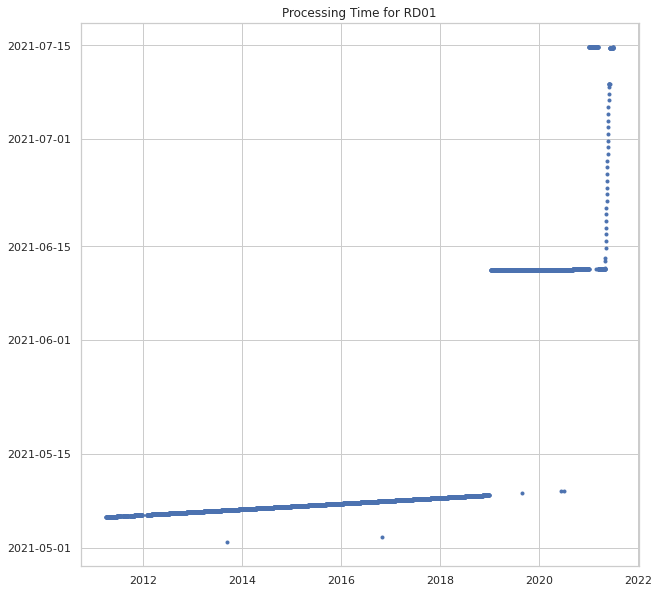

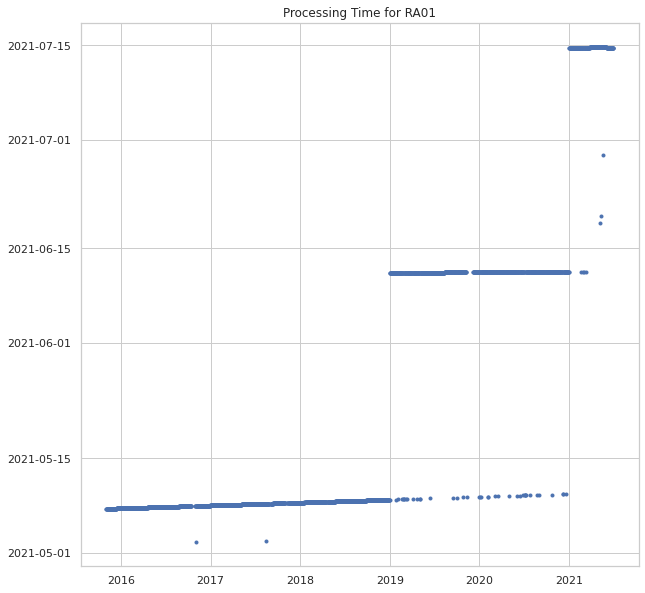

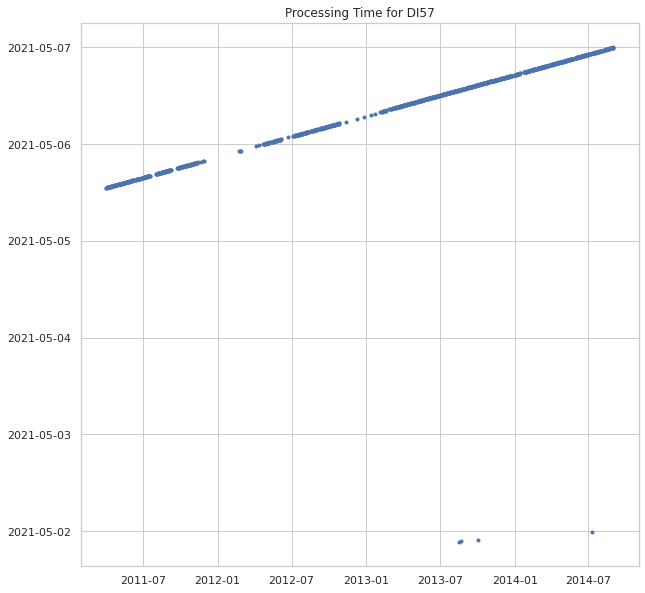

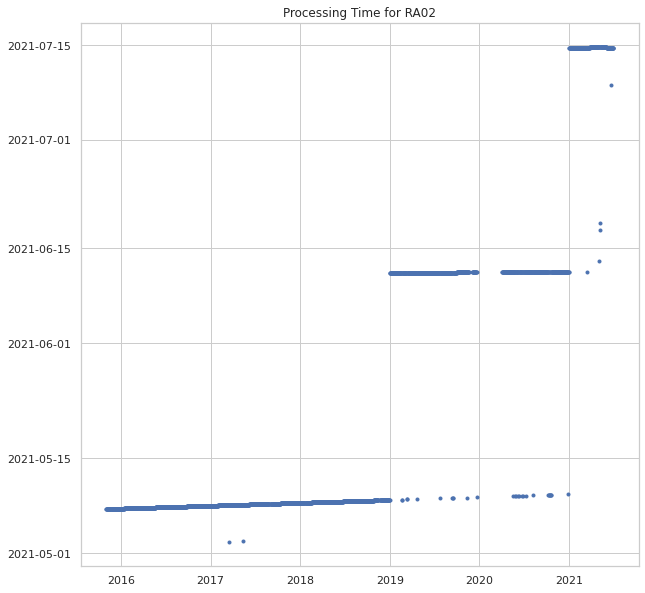

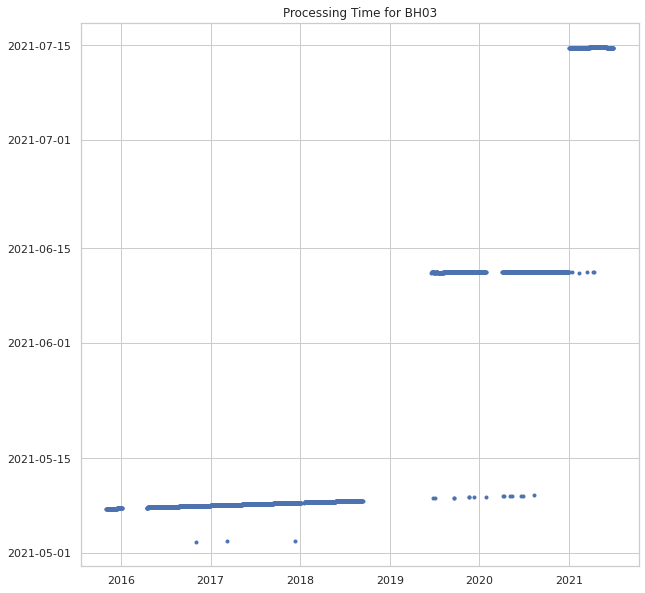

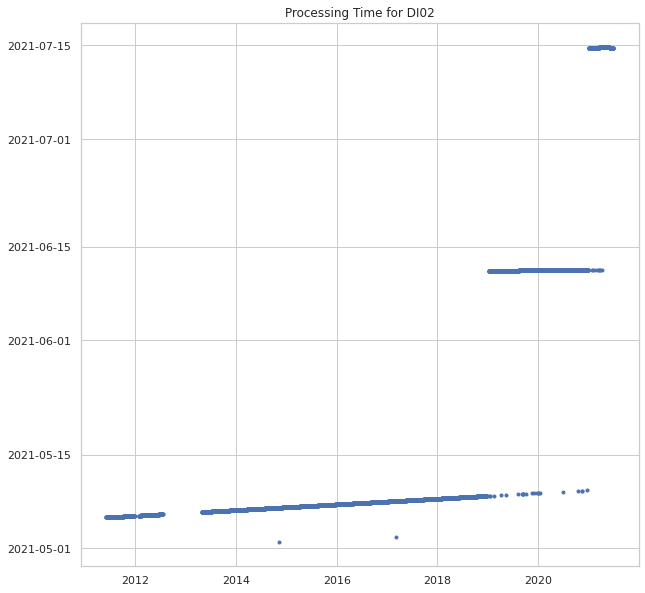

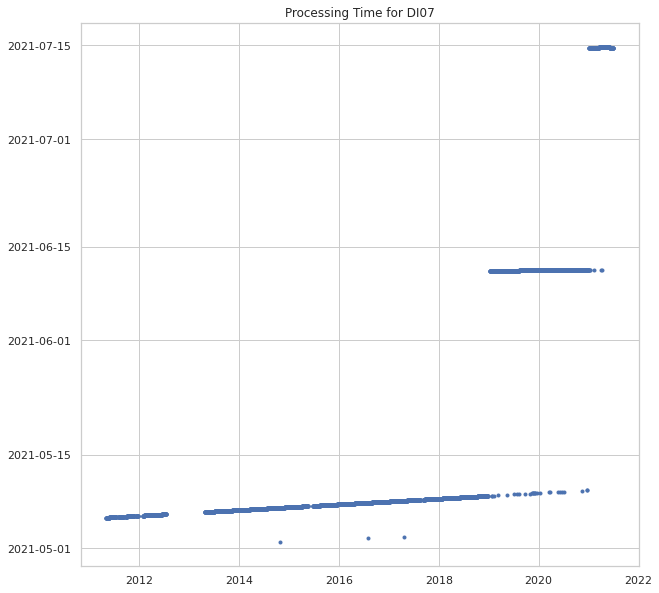

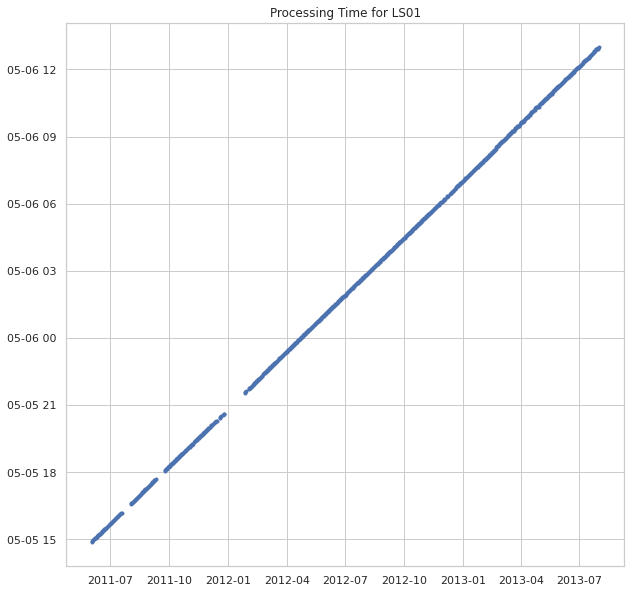

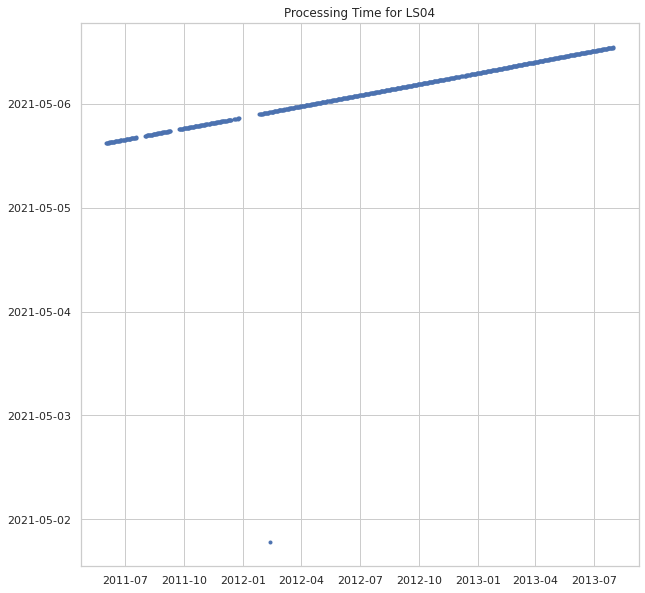

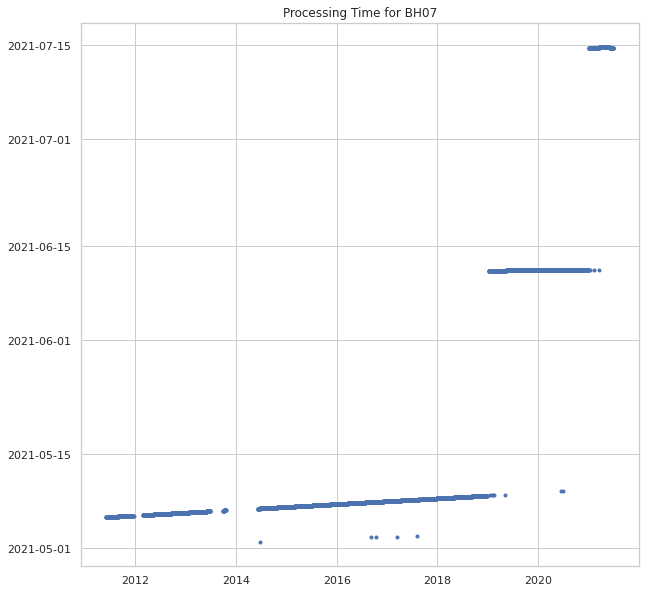

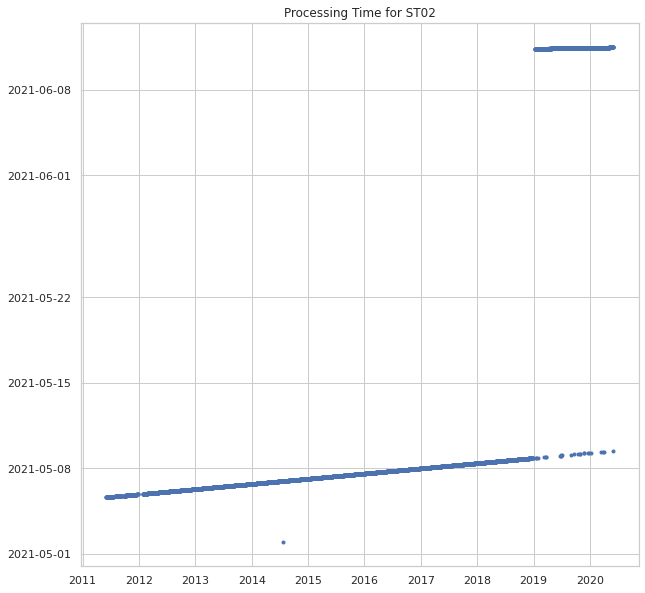

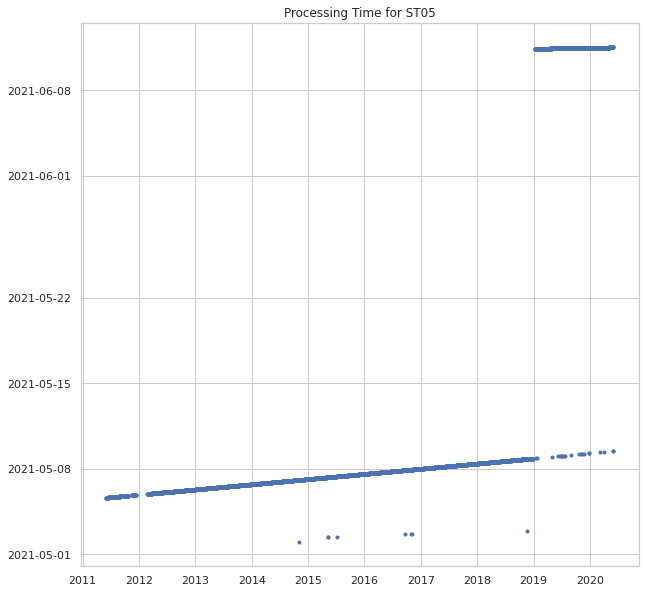

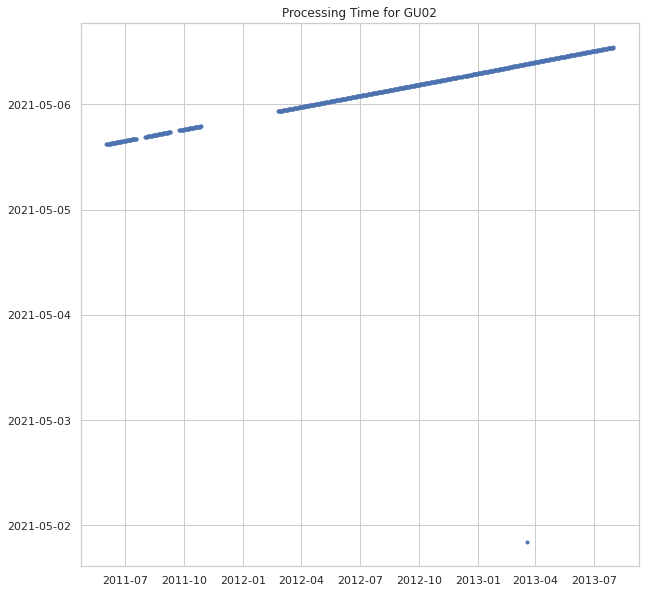

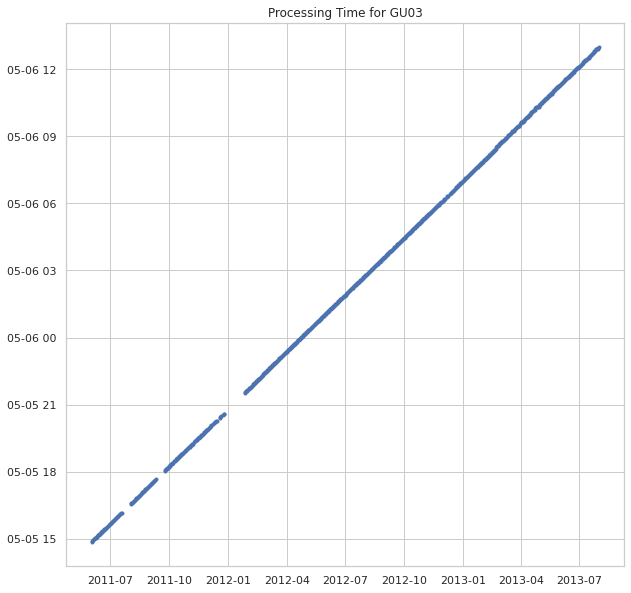

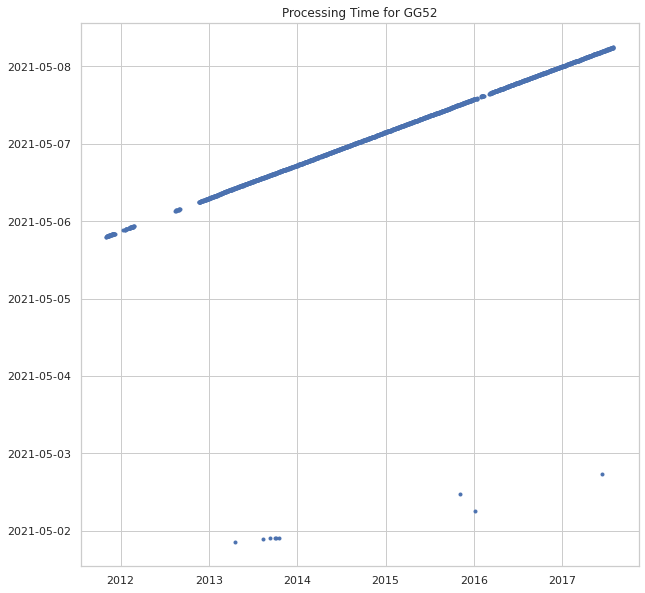

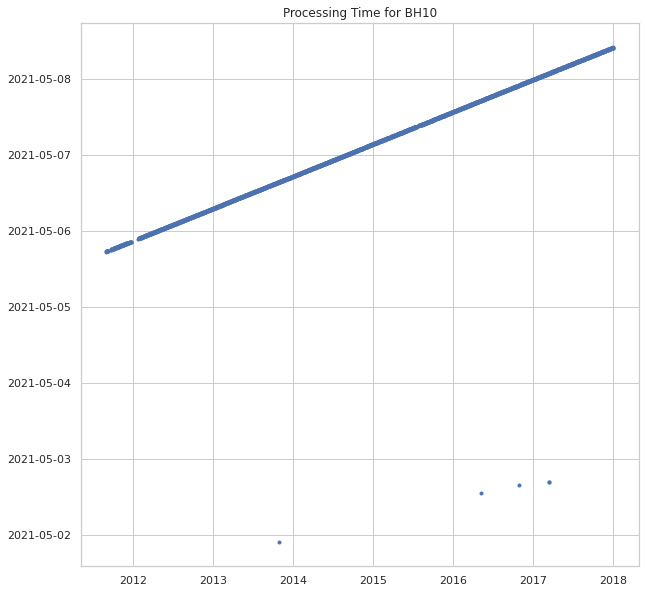

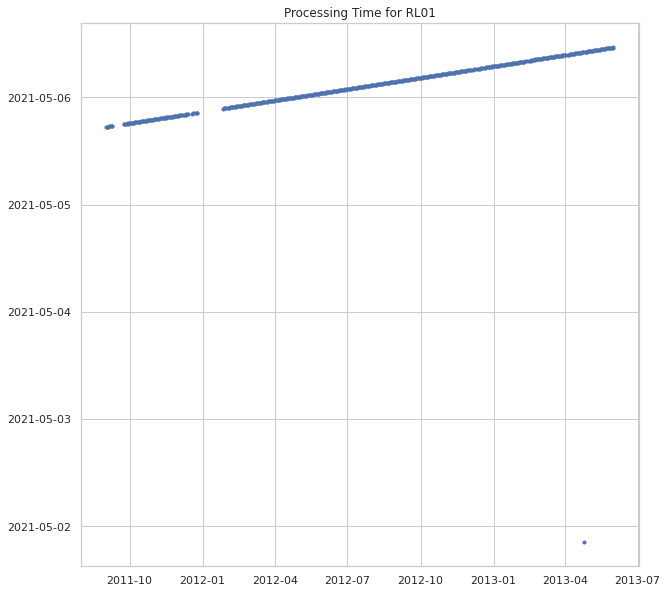

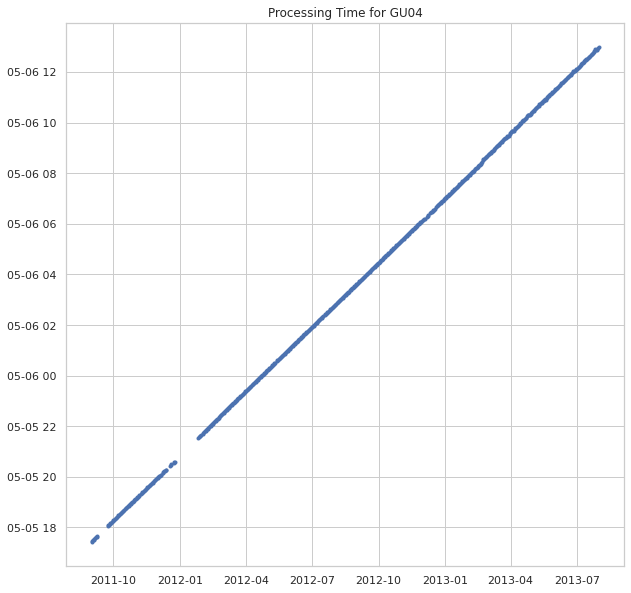

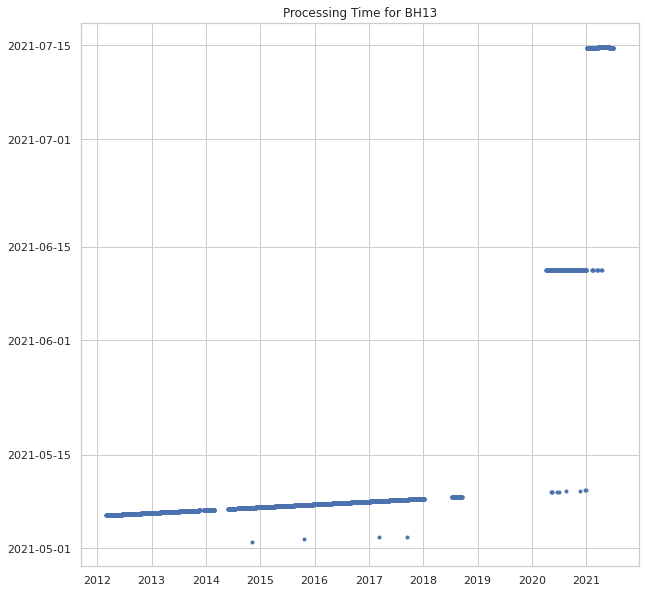

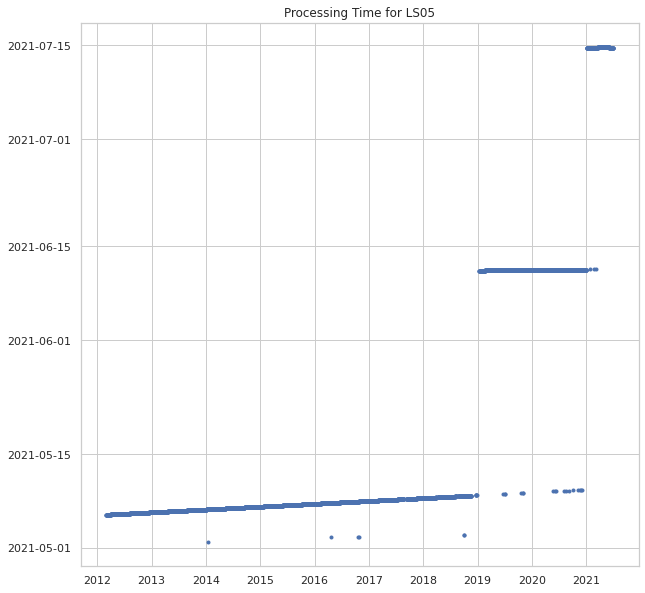

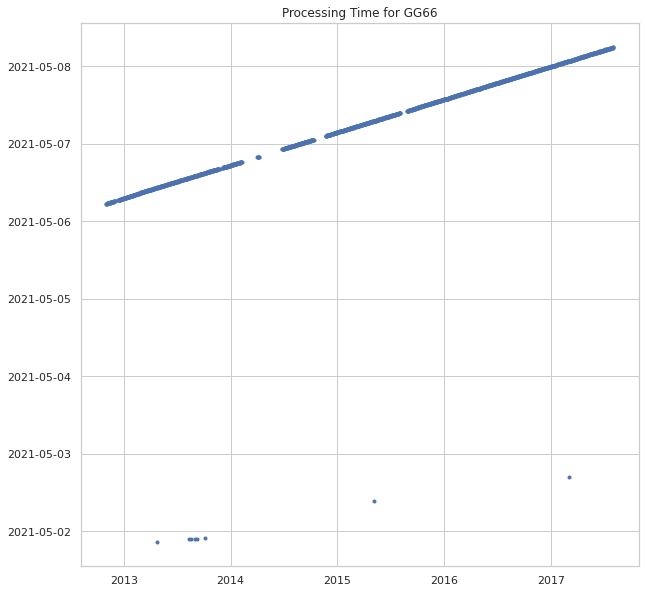

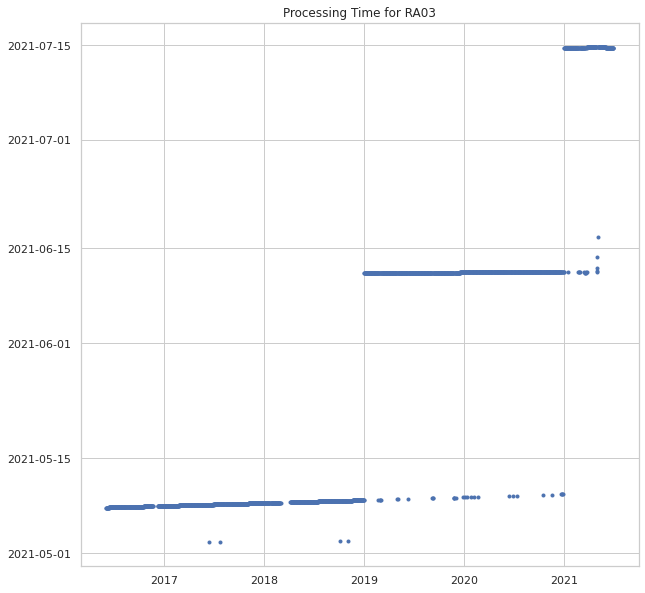

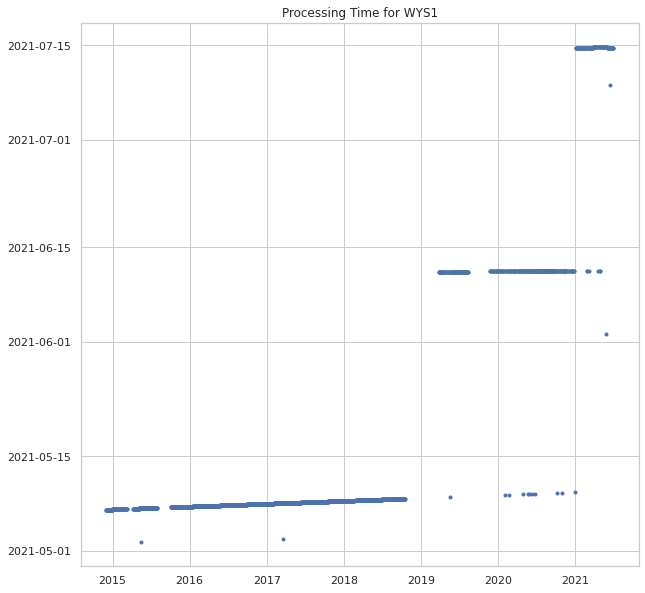

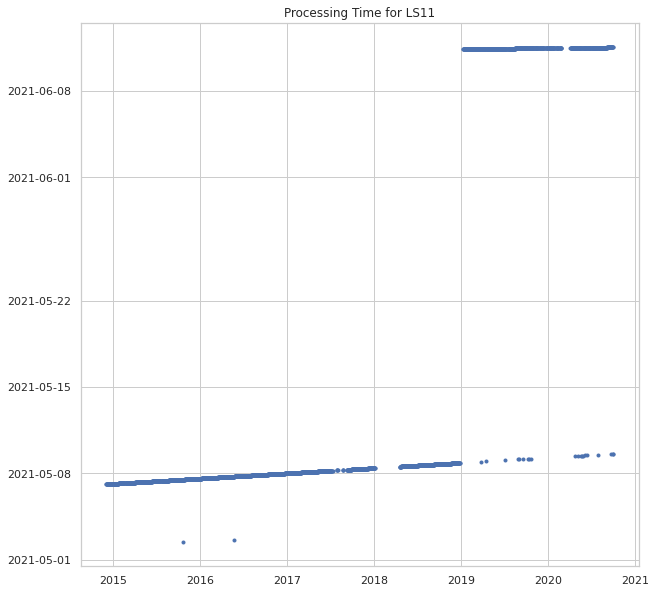

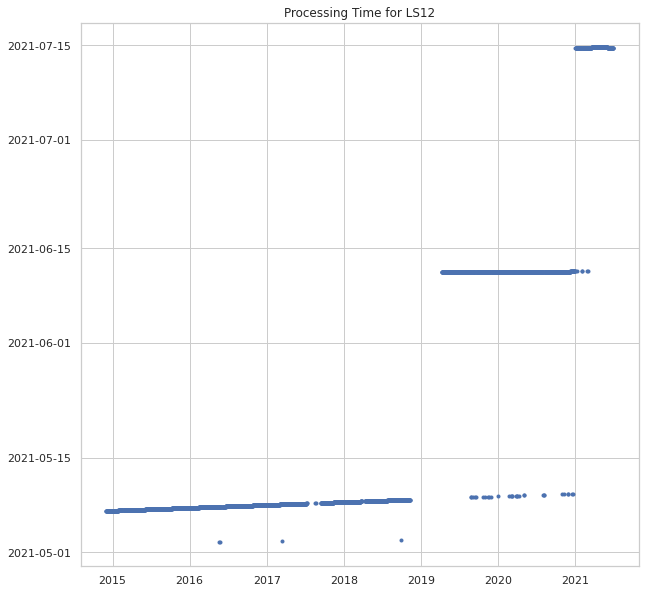

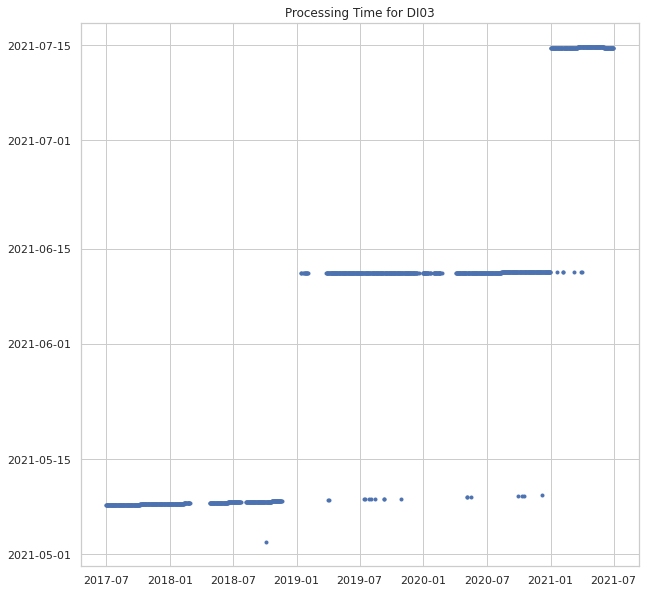

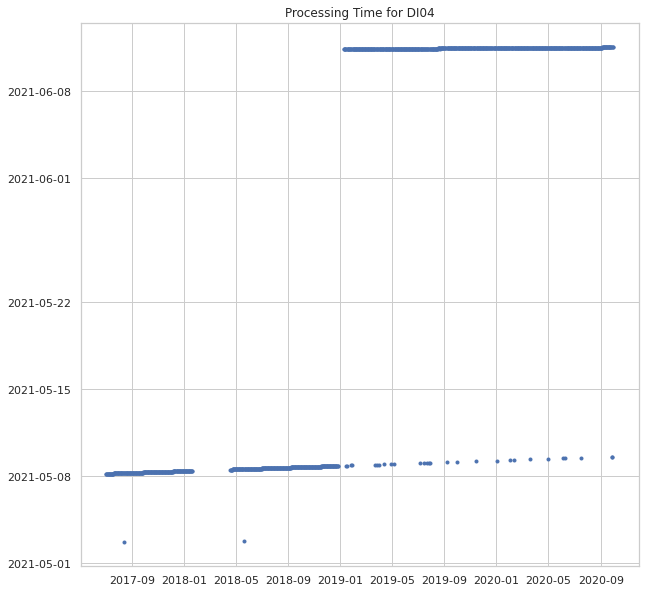

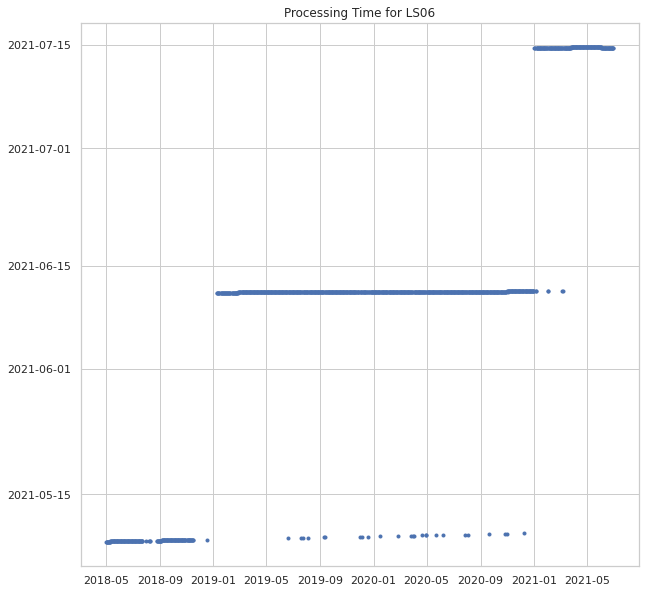

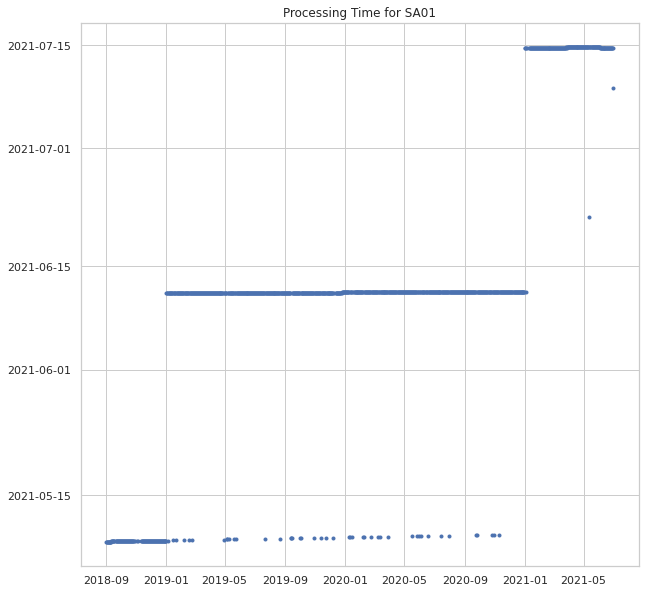

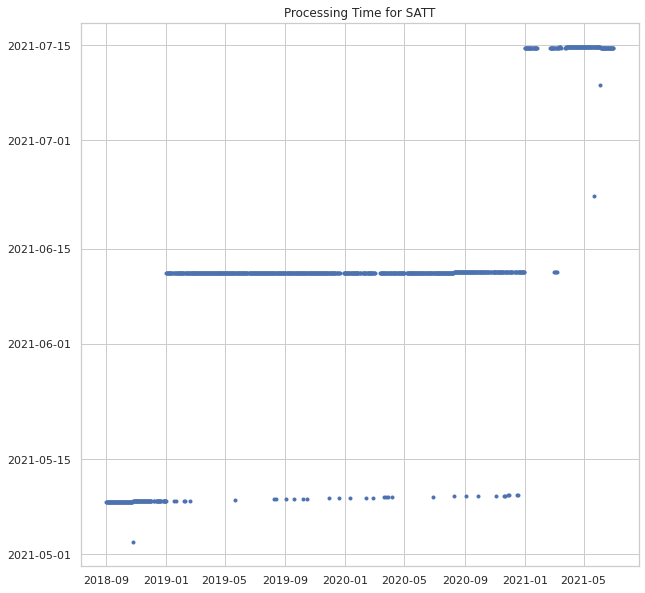

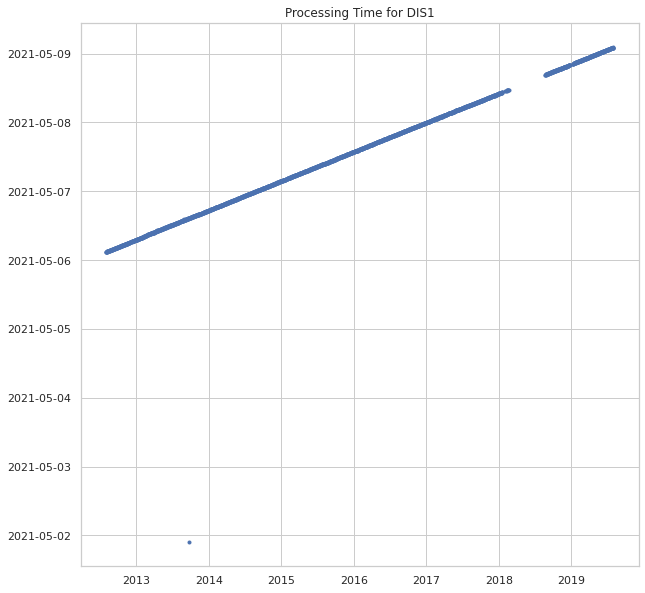

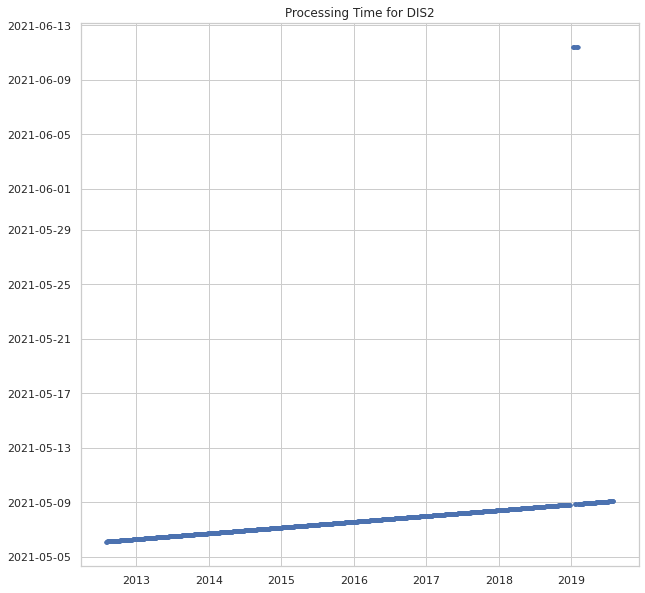

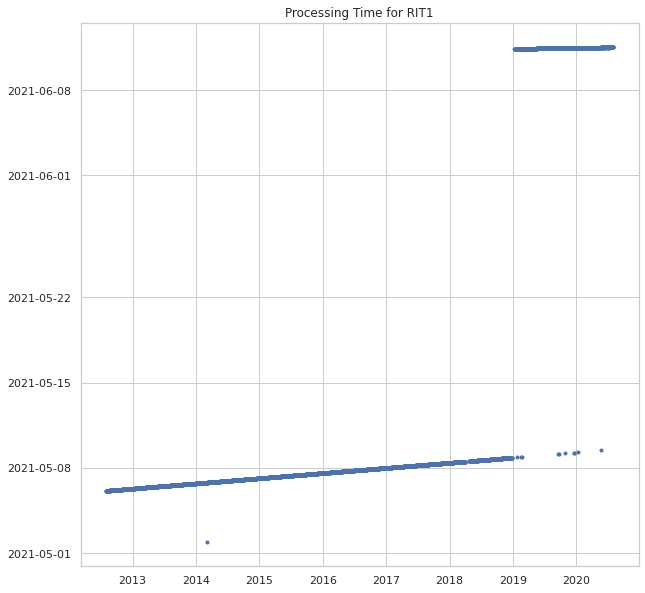

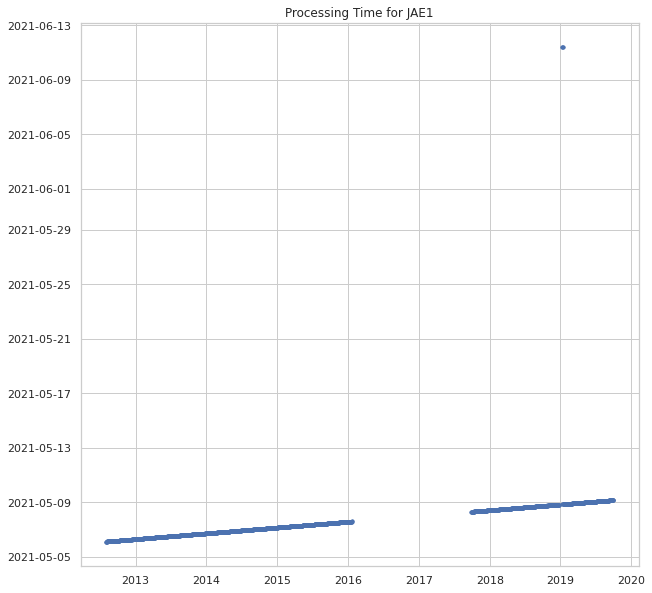

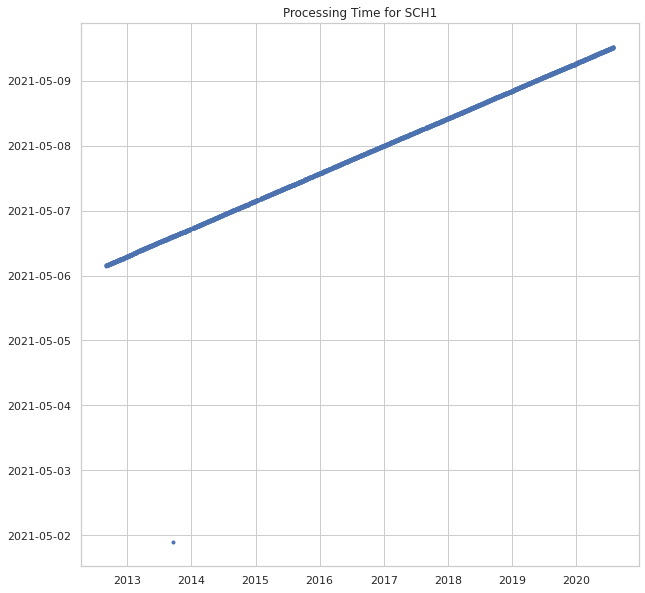

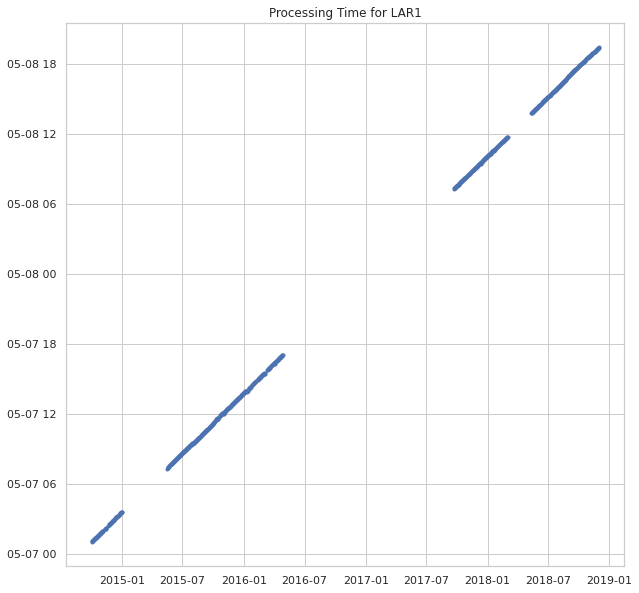

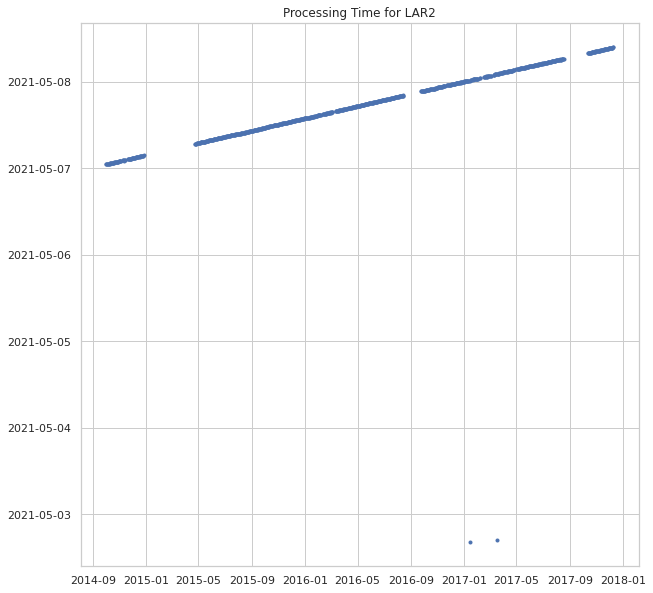

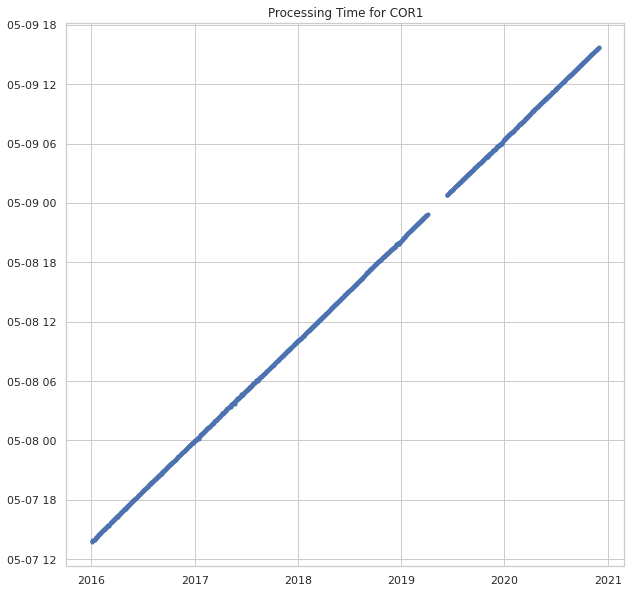

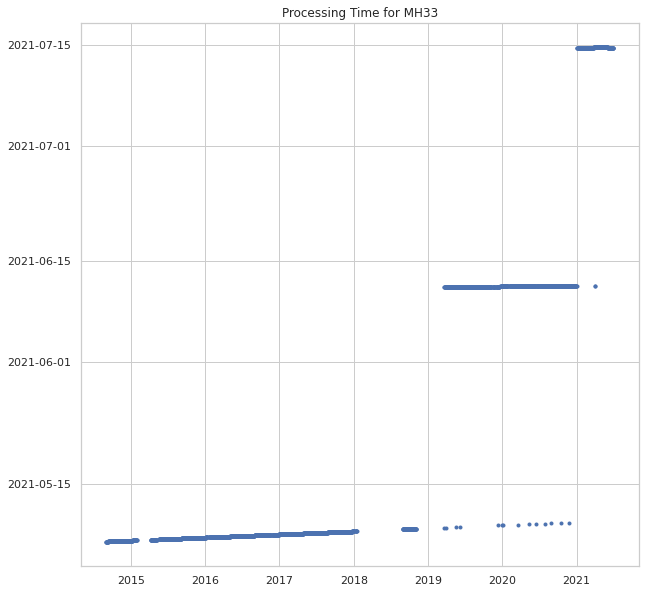

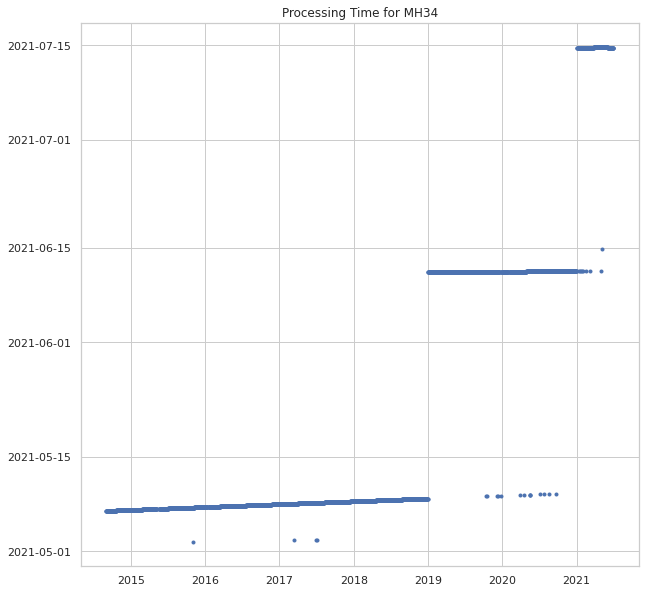

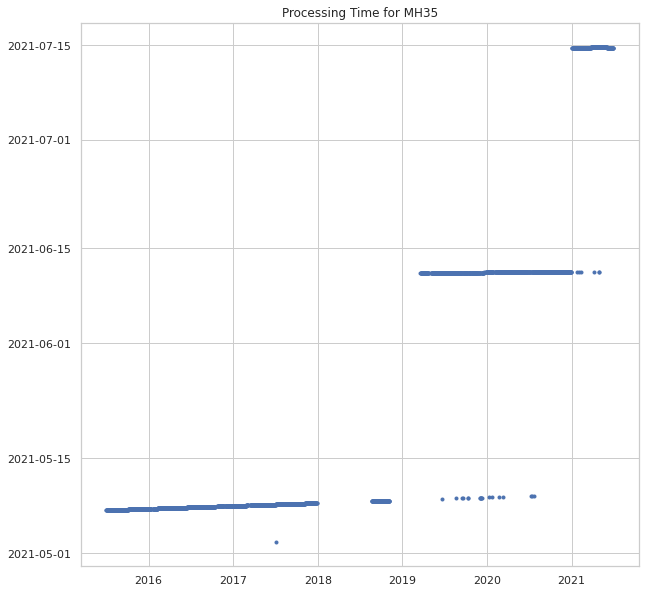

In [18]:
for depo, depo_line in DEPO_VS.items():
    for label in depo_line:
        print('Working on data of label {:s} and depo {:s}.'.format(label, depo))

    if depo[0:2] == 'MH':
        deployment = 'matterhorn'
    elif depo[0:2] == 'DH':
        deployment = 'dirruhorn'
    elif depo[0:2] == 'PE':
        deployment = 'permos'
    position = int(depo[2:4])

    
    linewidth_reg = 2

    for vsensor in list(vs for vs in sorted(list(depo_line[label]))):
        if vsensor == 'gps_differential__rtklib__daily':

### Extract full months only to prevent artifacts
            df = load_data(PATH_DATA + '/gnss_derived_data_products/', label, vsensor, year=year_list, file_type='csv')
#             print(df)
#             print(df.index)
            print(df.index[0])
            print(df.index[-1])
            t1 = df.index[0]
            t2 = df.index[-1]
            
            startday = df.index[0].day
            startday = t1 + pd.DateOffset(months=1) - pd.DateOffset(days=startday)
#             print(startday)
            endday = df.index[-1].day - 1
            endday = t2 - pd.DateOffset(days=endday)
#             print(endday)
            df = df[(df.index > startday) & (df.index < endday)]
#             print(df)
            df['processing_time [UTC]'] = pd.to_datetime(df['processing_time [UTC]'], unit='ms')
#             print(df)
        
#             dt.datetime.utcfromtimestamp(df['processing_time [UTC]']).strftime('%Y-%m-%d')

#             print(df.index[0])
#             print(df.index[-1])
            t1 = df.index[0]
            t2 = df.index[-1]
            trng_reindex = pd.date_range(t1, t2, freq='24h')

            plt.figure(facecolor='w', edgecolor='k', figsize=(10, 10))
            plt.subplots_adjust(wspace=0.2, hspace=0.4)
            plt.plot(df['processing_time [UTC]'], 'b.')
            plt.title('Processing Time for {:s}'.format(label))

            plt.savefig('{:s}/quality_plots/{:s}_{:s}_inventory.png'.format(PATH_DATA , label, vsensor), dpi=400)

Working on data of label RD01 and depo DH00.
2011-03-01 12:00:00+00:00
2021-07-12 12:00:00+00:00
Generating LOWESS smoothed data
Now Levelplotting


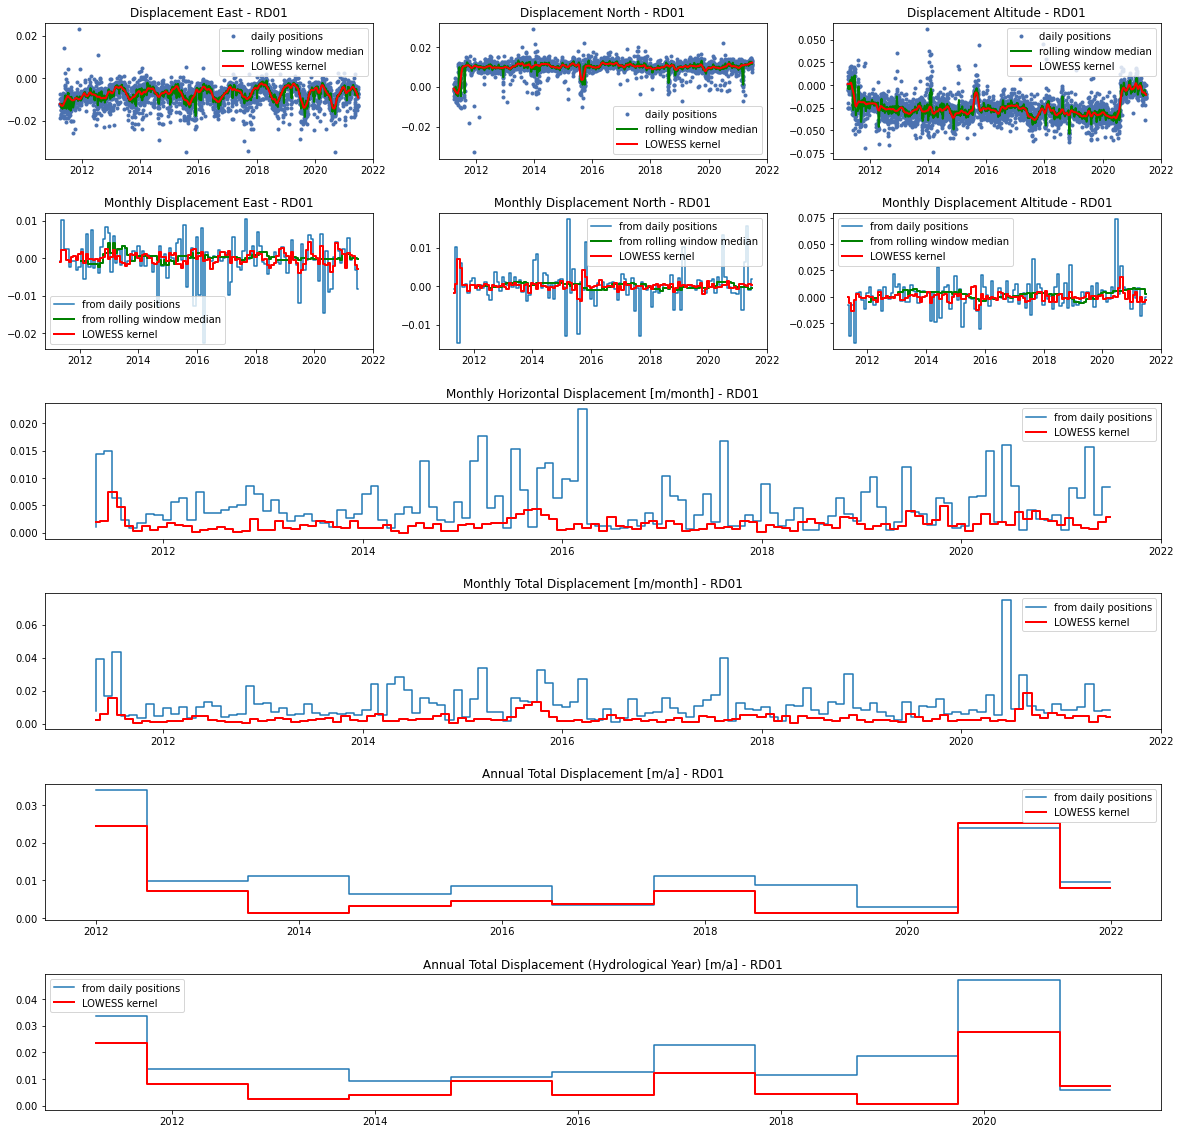

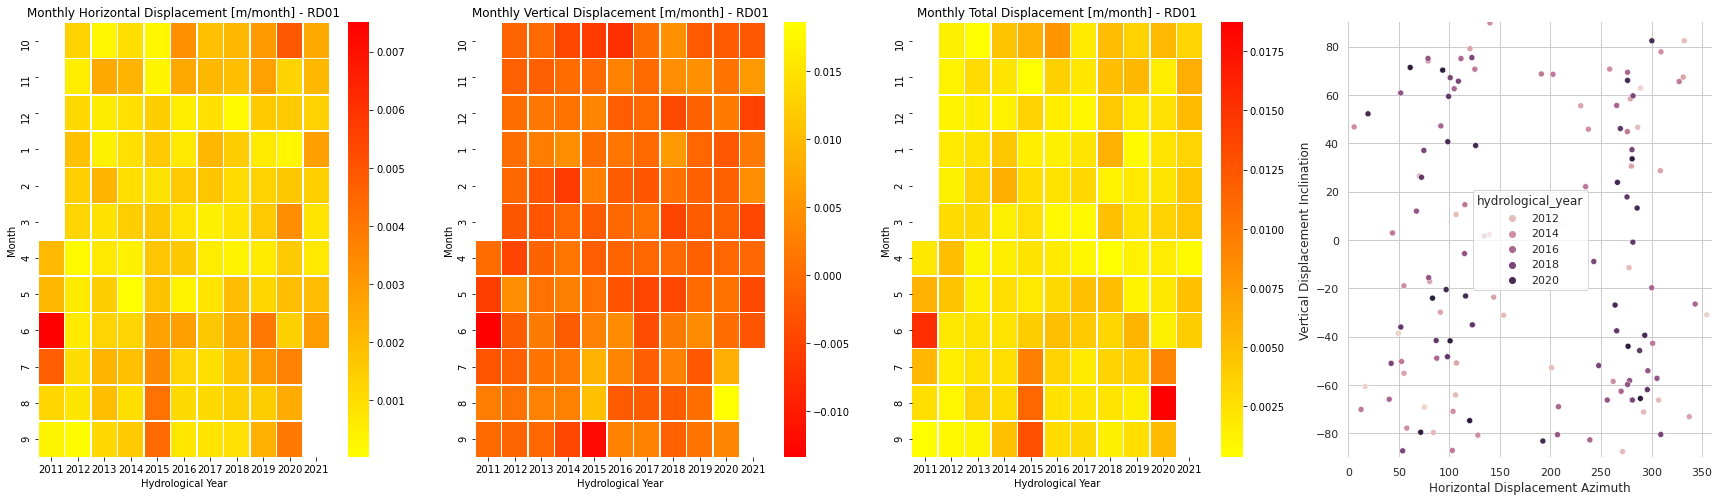

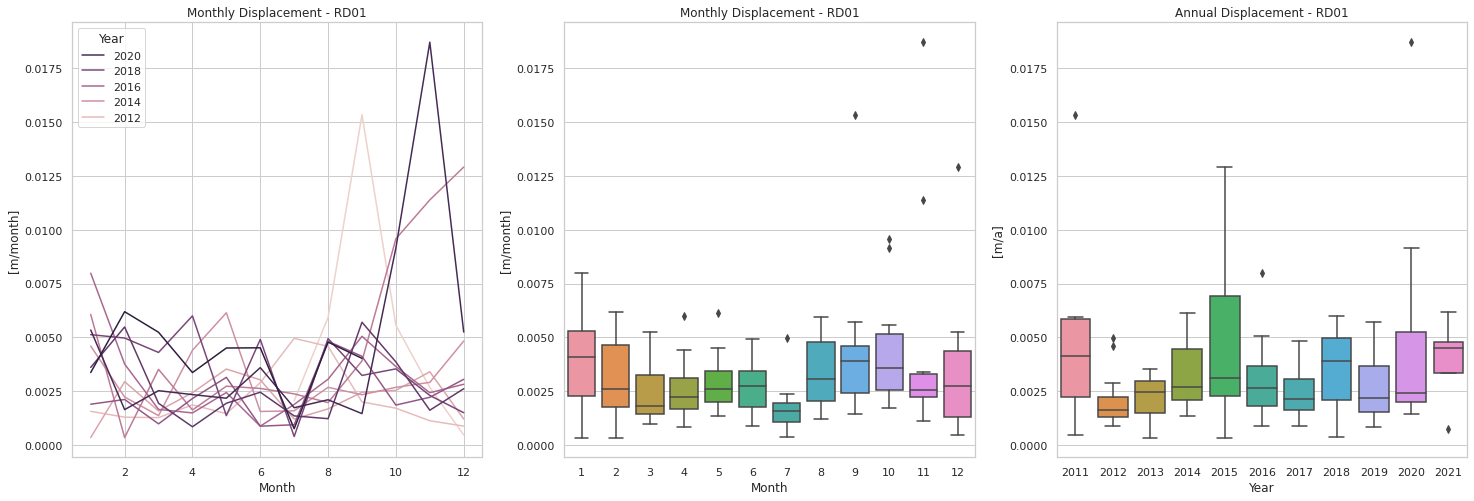

Working on data of label DI55 and depo DH05.
2011-03-09 12:00:00+00:00
2021-07-12 12:00:00+00:00
Generating LOWESS smoothed data
Now Levelplotting


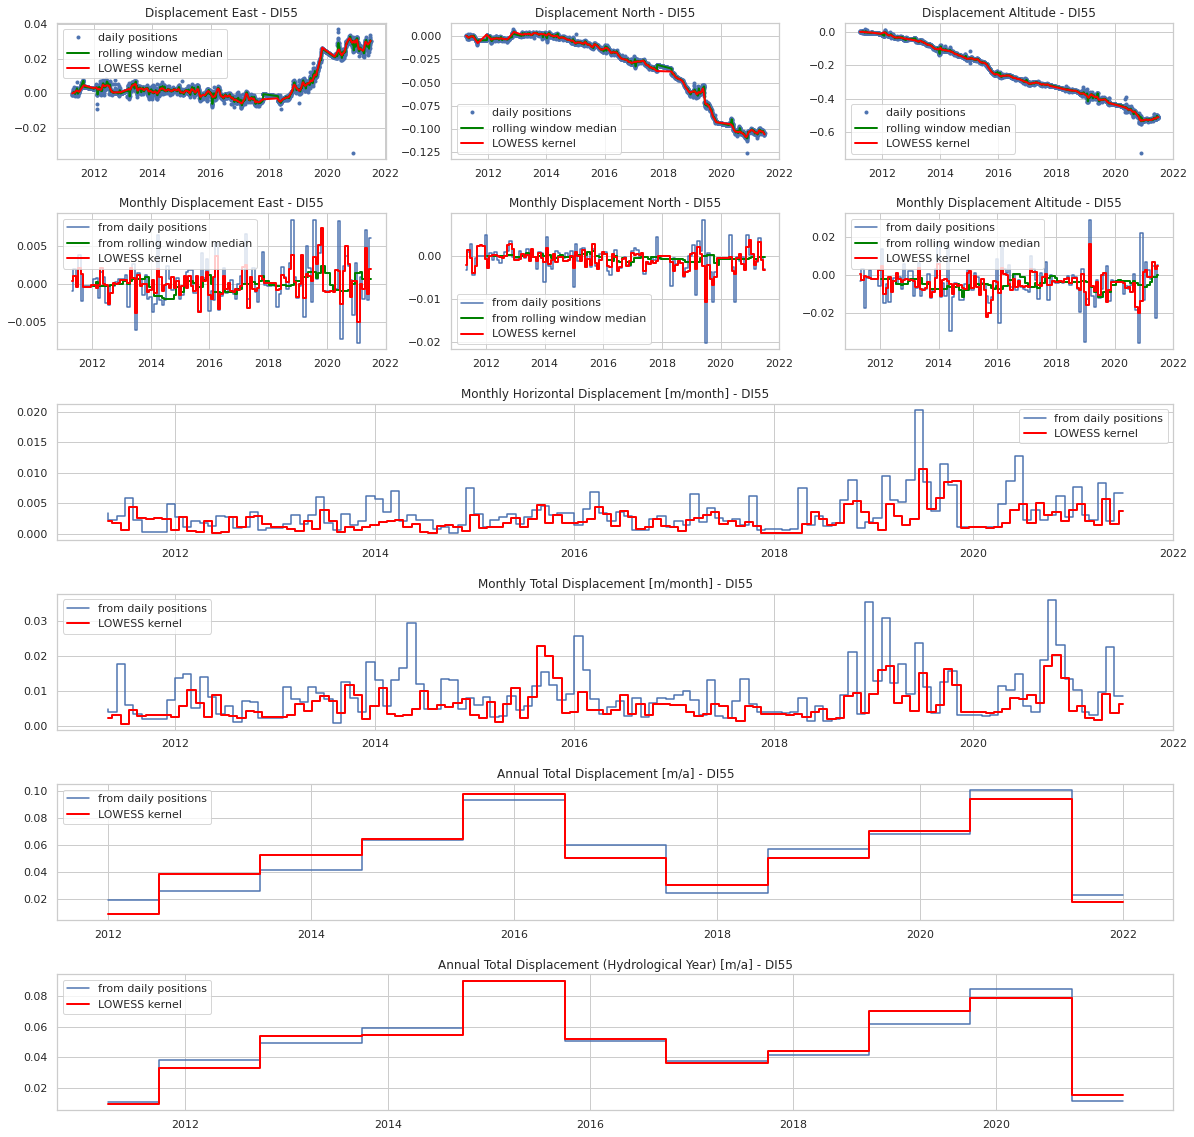

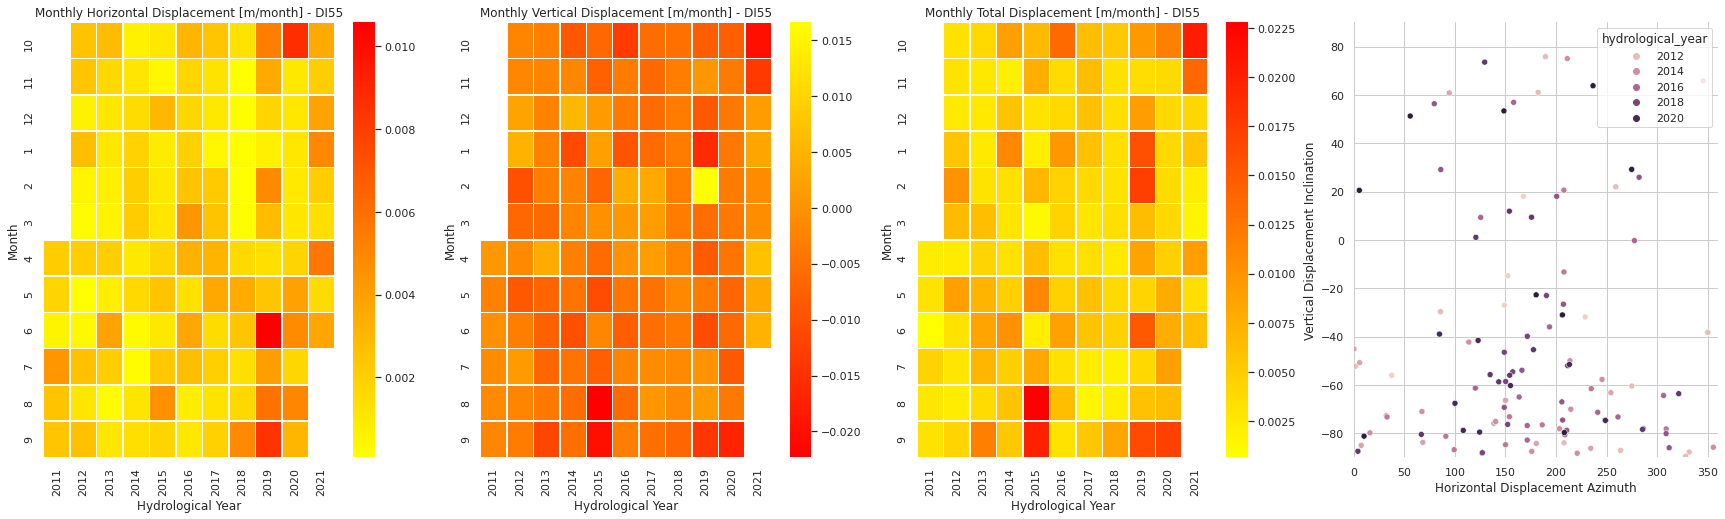

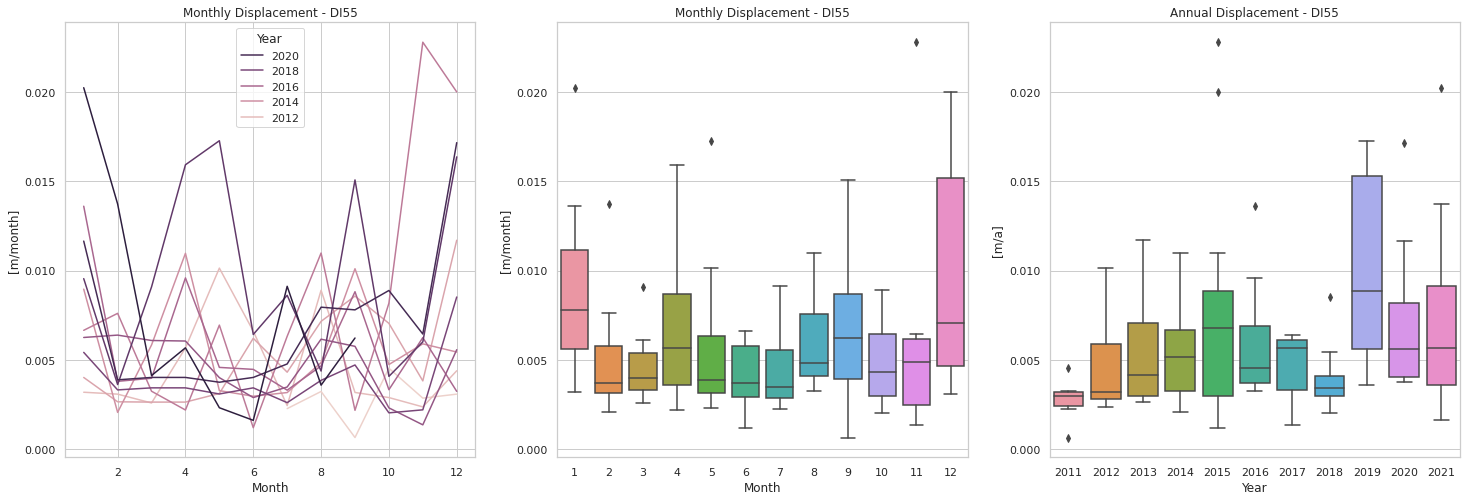

Working on data of label RA01 and depo DH06.
2015-10-08 12:00:00+00:00
2021-07-12 12:00:00+00:00
Generating LOWESS smoothed data
Now Levelplotting


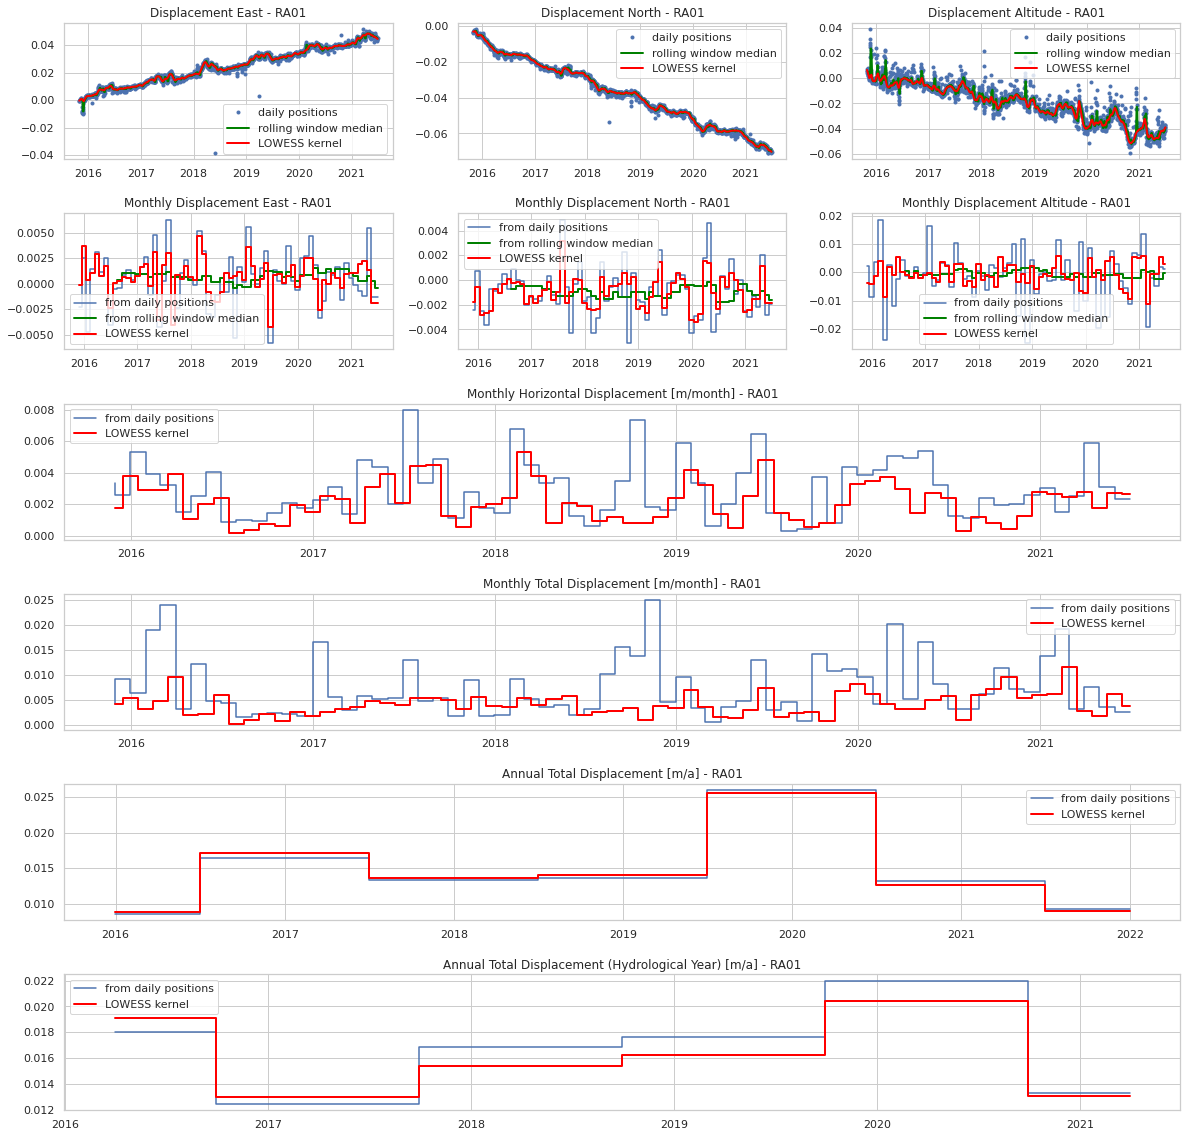

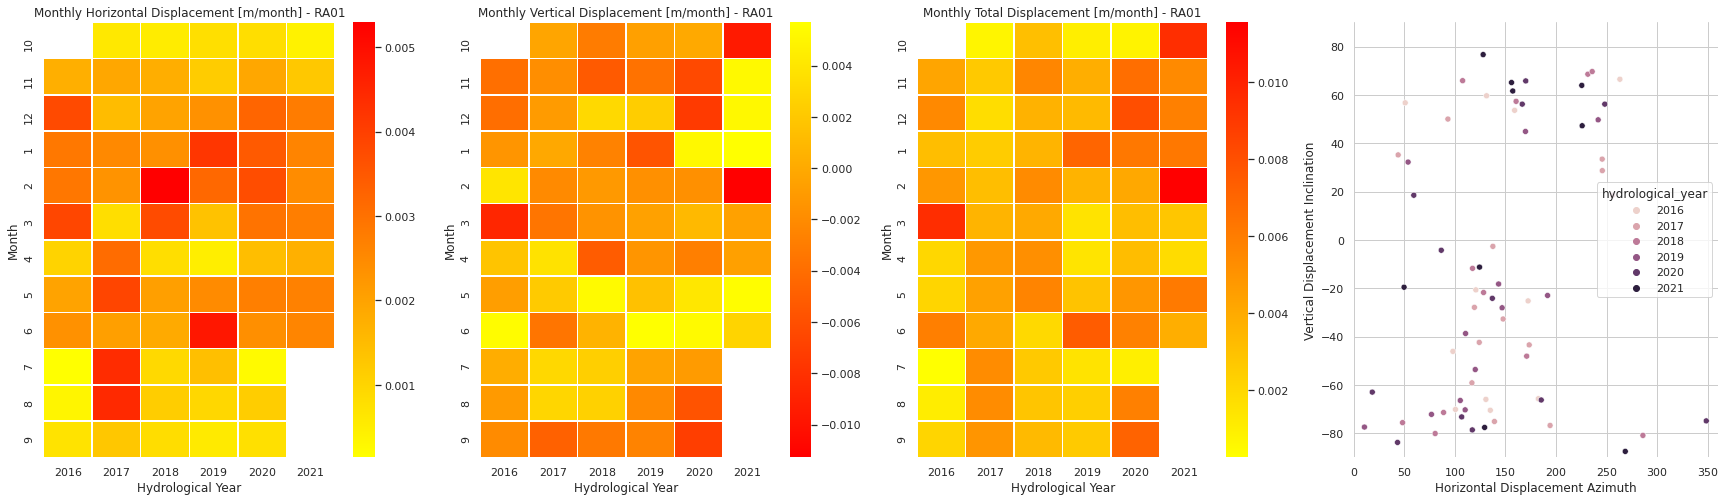

Working on data of label DI57 and depo DH07.
2011-03-02 12:00:00+00:00
2014-09-11 12:00:00+00:00
Generating LOWESS smoothed data


KeyboardInterrupt: 

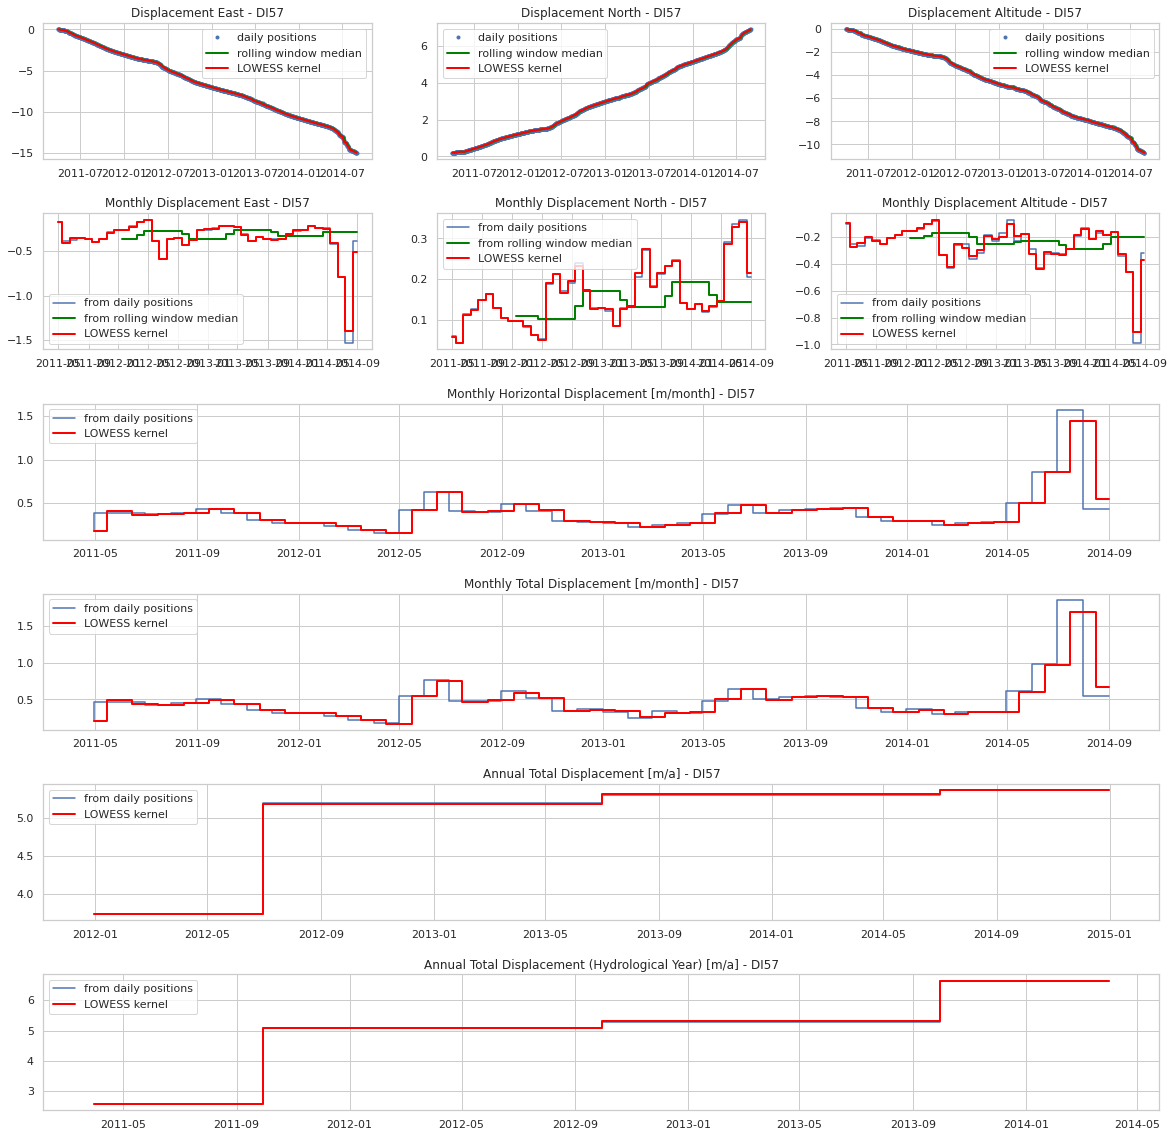

In [17]:
# Loop through keys (depo) in dictionary DEPO_VS
for depo, depo_line in DEPO_VS.items():
    for label in depo_line:
        print('Working on data of label {:s} and depo {:s}.'.format(label, depo))

    if depo[0:2] == 'MH':
        deployment = 'matterhorn'
    elif depo[0:2] == 'DH':
        deployment = 'dirruhorn'
    elif depo[0:2] == 'PE':
        deployment = 'permos'
    position = int(depo[2:4])

    
    linewidth_reg = 2

    for vsensor in list(vs for vs in sorted(list(depo_line[label]))):
        if vsensor == 'gps_differential__rtklib__daily':

### Extract full months only to prevent artifacts
            df = load_data(PATH_DATA + '/gnss_derived_data_products/', label, vsensor, year=year_list, file_type='csv')
#             print(df)
#             print(df.index)
            print(df.index[0])
            print(df.index[-1])
            t1 = df.index[0]
            t2 = df.index[-1]
            
            startday = df.index[0].day
            startday = t1 + pd.DateOffset(months=1) - pd.DateOffset(days=startday)
#             print(startday)
            endday = df.index[-1].day - 1
            endday = t2 - pd.DateOffset(days=endday)
#             print(endday)
            df = df[(df.index > startday) & (df.index < endday)]
#             print(df)

#             print(df.index[0])
#             print(df.index[-1])
            t1 = df.index[0]
            t2 = df.index[-1]
            trng_reindex = pd.date_range(t1, t2, freq='24h')

#Generating daily LOWESS
            print('Generating LOWESS smoothed data')
            # https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html#statsmodels.nonparametric.smoothers_lowess.lowess
            
            rolling_window_median = 10
            
            fraction = 0.015    # The fraction of the data used when estimating each y-value.
            it_reweighting = 5  # The number of residual-based reweightings to perform.
            delta = 12.00        # Distance within which to use linear-interpolation instead of weighted regression.
        
            # tried 0.025 5
            lowess_e = lowess(df['e [m]'], df.index, frac = fraction, it = it_reweighting, delta = delta)
            lowess_n = lowess(df['n [m]'], df.index, frac = fraction, it = it_reweighting, delta = delta)
            lowess_h = lowess(df['h [m]'], df.index, frac = (1* fraction), it = (1* it_reweighting), delta = (1* delta))
#             lowess_h = lowess(df['h [m]'], df.index, frac = (10 * fraction), it = (100* it_reweighting), delta = (100 * delta))
            timestamp_e = pd.to_datetime((lowess_e[:,0]//1000000000).astype('datetime64[s]')).tz_localize('UTC')
            timestamp_n = pd.to_datetime((lowess_n[:,0]//1000000000).astype('datetime64[s]')).tz_localize('UTC')
            timestamp_h = pd.to_datetime((lowess_h[:,0]//1000000000).astype('datetime64[s]')).tz_localize('UTC')

            dfe = pd.DataFrame(lowess_e[:,1], index=timestamp_e, columns=['e_filt'])
            dfn = pd.DataFrame(lowess_n[:,1], index=timestamp_n, columns=['n_filt'])
            dfh = pd.DataFrame(lowess_h[:,1], index=timestamp_h, columns=['h_filt'])

            dfe = dfe.reindex(trng_reindex)
            dfn = dfn.reindex(trng_reindex)
            dfh = dfh.reindex(trng_reindex)
            # print(dfe)

            df = df.join(dfe)
            df = df.join(dfn)
            df = df.join(dfh)
            # print(df)

#             fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30, 5))
#             ax1.plot(df['e [m]'], 'b.')
#             ax1.plot(df['e [m]'].rolling(rolling_width).median(), color='green', linewidth=linewidth_reg)
#             ax1.plot(dfe, color='red', linewidth=linewidth_reg)
#             ax1.set_title('East')
#             ax2.plot(df['n [m]'], 'b.')
#             ax2.plot(df['n [m]'].rolling(rolling_width).median(), color='green', linewidth=linewidth_reg)
#             ax2.plot(dfn, color='red', linewidth=linewidth_reg)
#             ax2.set_title('North')
#             ax3.plot(df['h [m]'], 'b.')
#             ax3.plot(df['h [m]'].rolling(rolling_width).median(), color='green', linewidth=linewidth_reg)
#             ax3.plot(dfh, color='red', linewidth=linewidth_reg)
#             ax3.set_title('Altitude')
#             plt.show()
#             plt.savefig('{:s}/test_plots/{:s}_lowess.png'.format(PATH_DATA , label), dpi=300)


# Preparing Downsampled Data
            df1d = df.resample('D').median()
            df1d = df1d.interpolate(method='linear')
            # df1 = df.rolling(15).median()
            df1d['hydrological_year'] = (df1d.index + pd.DateOffset(months=3)).year
            df1d['year'] = df1d.index.year
            df1d['month'] = df1d.index.month
            # print(df1d)

            df1m  = df1d.groupby(pd.Grouper(freq='M')).diff()
            df1m  = df1m.groupby(pd.Grouper(freq='M')).aggregate(np.sum)
            df1m['hydrological_year'] = (df1m.index + pd.DateOffset(months=3)).year
            df1m['hydrological_month'] = (df1m.index + pd.DateOffset(months=3)).month
            df1m['year'] = df1m.index.year
            df1m['month'] = df1m.index.month
            # print(df1m)

            df1a  = df1d.groupby(pd.Grouper(freq='Y')).diff()
            df1a  = df1a.groupby(pd.Grouper(freq='Y')).aggregate(np.sum)
            df1a['hydrological_year'] = (df1a.index + pd.DateOffset(months=3)).year
            df1a['year'] = df1a.index.year
            df1a['month'] = df1a.index.month
            # print(df1a)

            df1ha  = df1d.groupby(pd.Grouper(key='hydrological_year')).diff()
            # print(df1ha)
            df1ha['hydrological_year'] = pd.to_datetime((df1ha.index + pd.DateOffset(months=3)).year, format='%Y') + pd.DateOffset(months=3) - pd.DateOffset(days=1)
            # print(df1ha)
            df1ha  = df1ha.groupby(pd.Grouper(key='hydrological_year')).aggregate(np.sum)
            df1ha['hydrological_year'] = (df1ha.index + pd.DateOffset(months=3)).year
            df1ha['year'] = df1ha.index.year
            df1ha['month'] = df1ha.index.month
            # print(df1ha)

# old R code
#             horiz_displacement = round(sqrt(e_displacement^2 + n_displacement^2), digits=4)
#             horiz_azimuth <- round(180/pi * atan2(e_displacement, n_displacement), digits=3)
#             if (horiz_azimuth < 0) {
#             horiz_azimuth <- horiz_azimuth + 360
#             }
#             vertical_displacement = round(h_displacement, digits=4)
#             total_displacement = round(sqrt(e_displacement^2 + n_displacement^2 + h_displacement^2), digits=4)
#             inclination = round(90 - (180/pi * acos(vertical_displacement/total_displacement)), digits=2)


            df1m_diff = pd.DataFrame((df1m['e [m]'].pow(2) + df1m['n [m]'].pow(2)).pow(1./2), columns=['horiz_displacement'])
            df1m_diff = df1m_diff.join(pd.DataFrame((df1m['e_filt'].pow(2) + df1m['n_filt'].pow(2)).pow(1./2), columns=['horiz_displacement_filt']))
        
            df1m_diff = df1m_diff.join(df1m['h [m]'])
            df1m_diff.rename(columns={'h [m]':'vertical_displacement'}, inplace=True)
            df1m_diff = df1m_diff.join(df1m['h_filt'])
            df1m_diff.rename(columns={'h_filt':'vertical_displacement_filt'}, inplace=True)
            
            df1m_diff = df1m_diff.join(pd.DataFrame((df1m['e [m]'].pow(2) + df1m['n [m]'].pow(2) + df1m['h [m]'].pow(2)).pow(1./2), columns=['total_displacement']))
            df1m_diff = df1m_diff.join(pd.DataFrame((df1m['e_filt'].pow(2) + df1m['n_filt'].pow(2) + df1m['h_filt'].pow(2)).pow(1./2), columns=['total_displacement_filt']))

            df1m_diff = df1m_diff.join(pd.DataFrame(180/math.pi * np.arctan2(df1m['e [m]'], df1m['n [m]']), columns=['horiz_azimuth']))
            df1m_diff.loc[df1m_diff['horiz_azimuth'] < 0, 'horiz_azimuth'] = df1m_diff['horiz_azimuth'] + 360
            df1m_diff = df1m_diff.join(pd.DataFrame(180/math.pi * np.arctan2(df1m['e_filt'], df1m['n_filt']), columns=['horiz_azimuth_filt']))
            df1m_diff.loc[df1m_diff['horiz_azimuth_filt'] < 0, 'horiz_azimuth_filt'] = df1m_diff['horiz_azimuth_filt'] + 360


            df1m_diff = df1m_diff.join(pd.DataFrame(90 - (180/math.pi * np.arccos(np.divide(df1m_diff['vertical_displacement'], df1m_diff['total_displacement']))), columns=['inclination']))
            df1m_diff = df1m_diff.join(pd.DataFrame(90 - (180/math.pi * np.arccos(np.divide(df1m_diff['vertical_displacement_filt'], df1m_diff['total_displacement_filt']))), columns=['inclination_filt']))

            df1m_diff['hydrological_year'] = (df1m_diff.index + pd.DateOffset(months=3)).year
            df1m_diff['hydrological_month'] = (df1m_diff.index + pd.DateOffset(months=3)).month
            df1m_diff['year'] = df1m_diff.index.year
            df1m_diff['month'] = df1m_diff.index.month
            # print(df1m_diff)

            df1a_diff = pd.DataFrame((df1a['e [m]'].pow(2) + df1a['n [m]'].pow(2) + df1a['h [m]'].pow(2)).pow(1./2), columns=['total_displacement'])
            df1a_diff = df1a_diff.join(pd.DataFrame((df1a['e_filt'].pow(2) + df1a['n_filt'].pow(2) + df1a['h_filt'].pow(2)).pow(1./2), columns=['total_displacement_filt']))
            df1a_diff['hydrological_year'] = (df1a_diff.index + pd.DateOffset(months=3)).year
            df1a_diff['year'] = df1a_diff.index.year
            df1a_diff['month'] = df1a_diff.index.month
            # print(df1a_diff)

            df1ha_diff = pd.DataFrame((df1ha['e [m]'].pow(2) + df1ha['n [m]'].pow(2) + df1ha['h [m]'].pow(2)).pow(1./2), columns=['total_displacement'])
            df1ha_diff = df1ha_diff.join(pd.DataFrame((df1ha['e_filt'].pow(2) + df1ha['n_filt'].pow(2) + df1ha['h_filt'].pow(2)).pow(1./2), columns=['total_displacement_filt']))
            df1ha_diff['hydrological_year'] = (df1ha_diff.index + pd.DateOffset(months=3)).year
            df1ha_diff['year'] = df1ha_diff.index.year
            df1ha_diff['month'] = df1ha_diff.index.month
            # print(df1ha_diff)

### Now Plotting Stuff
            fig = plt.figure(facecolor='w', edgecolor='k', figsize=(20, 20))
            plt.subplots_adjust(wspace=0.2, hspace=0.4)
            gs = fig.add_gridspec(6, 3)
            f_ax1 = fig.add_subplot(gs[0, 0])
            f_ax2 = fig.add_subplot(gs[0, 1])
            f_ax3 = fig.add_subplot(gs[0, 2])
            f_ax4 = fig.add_subplot(gs[1, 0])
            f_ax5 = fig.add_subplot(gs[1, 1])
            f_ax6 = fig.add_subplot(gs[1, 2])
            f_ax7 = fig.add_subplot(gs[2, :])
            f_ax8 = fig.add_subplot(gs[3, :])
            f_ax9 = fig.add_subplot(gs[4, :])
            f_ax10 = fig.add_subplot(gs[5, :])

            f_ax1.plot(df1d['e [m]'], 'b.', label = 'daily positions') 
            f_ax1.plot(df1d['e [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, label = 'rolling window median')
            f_ax1.plot(df1d['e_filt'], color='red', linewidth=linewidth_reg, label ='LOWESS kernel')
            f_ax1.set_title('Displacement East - {:s}'.format(label))
            f_ax1.legend()

            f_ax2.plot(df1d['n [m]'], 'b.', label = 'daily positions') 
            f_ax2.plot(df1d['n [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, label = 'rolling window median')
            f_ax2.plot(df1d['n_filt'], color='red', linewidth=linewidth_reg, label ='LOWESS kernel')
            f_ax2.set_title('Displacement North - {:s}'.format(label))
            f_ax2.legend()

            f_ax3.plot(df1d['h [m]'], 'b.', label = 'daily positions') 
            f_ax3.plot(df1d['h [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, label = 'rolling window median')
            f_ax3.plot(df1d['h_filt'], color='red', linewidth=linewidth_reg, label ='LOWESS kernel')
            f_ax3.set_title('Displacement Altitude - {:s}'.format(label))
            f_ax3.legend()

            f_ax4.plot(df1m['e [m]'], drawstyle="steps-mid", label = 'from daily positions') 
            f_ax4.plot(df1m['e [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, drawstyle="steps-mid", label = 'from rolling window median')
            f_ax4.plot(df1m['e_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax4.set_title('Monthly Displacement East - {:s}'.format(label))
            f_ax4.legend()
            
            f_ax5.plot(df1m['n [m]'], drawstyle="steps-mid", label = 'from daily positions') 
            f_ax5.plot(df1m['n [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, drawstyle="steps-mid", label = 'from rolling window median')
            f_ax5.plot(df1m['n_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax5.set_title('Monthly Displacement North - {:s}'.format(label))
            f_ax5.legend()

            f_ax6.plot(df1m['h [m]'], drawstyle="steps-mid", label = 'from daily positions') 
            f_ax6.plot(df1m['h [m]'].rolling(rolling_window_median).median(), color='green', linewidth=linewidth_reg, drawstyle="steps-mid", label = 'from rolling window median')
            f_ax6.plot(df1m['h_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax6.set_title('Monthly Displacement Altitude - {:s}'.format(label))
            f_ax6.legend()

            f_ax7.plot(df1m_diff['horiz_displacement'], drawstyle="steps-pre", label = 'from daily positions') 
            f_ax7.plot(df1m_diff['horiz_displacement_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax7.set_title('Monthly Horizontal Displacement [m/month] - {:s}'.format(label)) 
            f_ax7.legend()
            f_ax8.plot(df1m_diff['total_displacement'], drawstyle="steps-pre", label = 'from daily positions') 
            f_ax8.plot(df1m_diff['total_displacement_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax8.set_title('Monthly Total Displacement [m/month] - {:s}'.format(label))
            f_ax8.legend()
            f_ax9.plot(df1a_diff['total_displacement'], drawstyle="steps-mid", label = 'from daily positions') 
            f_ax9.plot(df1a_diff['total_displacement_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax9.set_title('Annual Total Displacement [m/a] - {:s}'.format(label))
            f_ax9.legend()
            f_ax10.plot(df1ha_diff['total_displacement'], drawstyle="steps-mid", label = 'from daily positions') 
            f_ax10.plot(df1ha_diff['total_displacement_filt'], color='red', linewidth=linewidth_reg, drawstyle="steps-mid", label ='LOWESS kernel')
            f_ax10.set_title('Annual Total Displacement (Hydrological Year) [m/a] - {:s}'.format(label))
            f_ax10.legend()
            plt.savefig('{:s}/test_plots/{:s}_{:s}_displacements.png'.format(PATH_DATA , label, vsensor), dpi=400)


### LEVELPLOT
            print('Now Levelplotting')

            df1m_horiz = df1m_diff.pivot(values = 'horiz_displacement_filt', columns = 'hydrological_year', index = 'hydrological_month')
            df1m_vertical = df1m_diff.pivot(values = 'vertical_displacement_filt', columns = 'hydrological_year', index = 'hydrological_month')
            df1m_total = df1m_diff.pivot(values = 'total_displacement_filt', columns = 'hydrological_year', index = 'hydrological_month')

            # fig = plt.figure(constrained_layout=True, figsize=(21, 29.7), facecolor='w', edgecolor='k')
            # gs = fig.add_gridspec(4, 2)
            # f_ax1 = fig.add_subplot(gs[:-2, :])
            # f_ax2 = fig.add_subplot(gs[2, 0])
            # f_ax3 = fig.add_subplot(gs[2, 0])
            # f_ax4 = fig.add_subplot(gs[2, 1])

            fig, (l_ax1, l_ax2, l_ax3, ax) = plt.subplots(nrows=1, ncols=4, figsize = (30, 8))
#             fig, l_ax1 = plt.subplots(figsize=(10, 10))
            linewidth = 0.5
            cmap = sns.color_palette('autumn', as_cmap = True)
            cmap_r = sns.color_palette('autumn_r', as_cmap = True)
            l_ax1 = plt.subplot(1, 4, 1)
            l_ax1 = sns.heatmap(df1m_horiz, linewidth = linewidth, cmap = cmap_r, yticklabels=['10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
            l_ax1.set_title('Monthly Horizontal Displacement [m/month] - {:s}'.format(label))
            l_ax1.set_ylabel('Month')
            l_ax1.set_xlabel('Hydrological Year')          

#             fig, l_ax2 = plt.subplots(figsize=(10, 10))
            l_ax1 = plt.subplot(1, 4, 2)
            l_ax2 = sns.heatmap(df1m_vertical, linewidth = linewidth, cmap = cmap, yticklabels=['10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
            l_ax2.set_title('Monthly Vertical Displacement [m/month] - {:s}'.format(label))
            l_ax2.set_ylabel('Month')
            l_ax2.set_xlabel('Hydrological Year')
            
#             fig, l_ax3 = plt.subplots(figsize=(10, 10))
            l_ax1 = plt.subplot(1, 4, 3)
            l_ax3 = sns.heatmap(df1m_total, linewidth = linewidth, cmap = cmap_r, yticklabels=['10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
            l_ax3.set_title('Monthly Total Displacement [m/month] - {:s}'.format(label))
            l_ax3.set_ylabel('Month')
            l_ax3.set_xlabel('Hydrological Year')

# Inclination/Azimuth
            sns.set_theme(style="whitegrid")
#             f, ax = plt.subplots(figsize=(10, 10))
            ax = plt.subplot(1, 4, 4)
            sns.despine(fig, left=True, bottom=True)
            sns.scatterplot(x="horiz_azimuth_filt", y="inclination_filt", data = df1m_diff, hue = 'hydrological_year', linewidth=0.5, ax=ax)
#             ax = sns.lmplot(x="horiz_azimuth_filt", y="inclination_filt", data = df1m_diff, hue = 'hydrological_year')
            ax.set_xlim(0, 360)
            ax.set_ylim(-90, 90)
            ax.set_ylabel('Vertical Displacement Inclination')
            ax.set_xlabel('Horizontal Displacement Azimuth')
            plt.savefig('{:s}/test_plots/{:s}_{:s}_heatmaps.png'.format(PATH_DATA , label, vsensor), dpi=400)


#SEASONAL BOX PLOTS
#             fig, f_ax1 = plt.subplots(figsize=(15, 6))
            fig, (f_ax1, f_ax2, f_ax3) = plt.subplots(1, 3, figsize=(25, 8))
            # palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
            palette = sns.color_palette()
            f_ax1 = plt.subplot(1, 3, 1)
            sns.lineplot(df1m_diff['hydrological_month'], df1m_diff['total_displacement_filt'], hue=df1m_diff['hydrological_year'])
            f_ax1.set_title('Monthly Displacement - {:s}'.format(label))
            f_ax1.set_xlabel('Month')
            f_ax1.set_ylabel('[m/month]')
            handles, labels = f_ax1.get_legend_handles_labels()
            f_ax1.legend(reversed(handles), reversed(labels), title='Year')

#             plt.savefig('{:s}/test_plots/{:s}_{:s}_seasonal1.png'.format(PATH_DATA , label, vsensor), dpi=300)

            f_ax2 = plt.subplot(1, 3, 2)
            sns.boxplot(df1m_diff['hydrological_month'], df1m_diff['total_displacement_filt'], ax=f_ax2)
            f_ax2.set_title('Monthly Displacement - {:s}'.format(label))
            f_ax2.set_xlabel('Month')
            f_ax2.set_ylabel('[m/month]')

#             fig, (f_ax3, f_ax4) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
            f_ax3 = plt.subplot(1, 3, 3)
            sns.boxplot(df1m_diff['hydrological_year'], df1m_diff['total_displacement_filt'], ax=f_ax3)
            f_ax3.set_title('Annual Displacement - {:s}'.format(label))
            f_ax3.set_xlabel('Year')
            f_ax3.set_ylabel('[m/a]')

            plt.savefig('{:s}/test_plots/{:s}_{:s}_statistics.png'.format(PATH_DATA , label, vsensor), dpi=400)
            plt.show()
            
